In [1]:
# Libraries just used for producing graphics in the page, not used 
# by any of the exercises.
# install.packages('rnaturalearth')
# install.packages('rnaturalearthdata')
library(repr)
library(rnaturalearth)
library(rnaturalearthdata)

# Practical One: GIS data and plotting

## Required packages

We will need to load the following packages. Remember to read [this guide on setting up
packages on your computer](../required_packages.md) if you are running these practicals
on your own machine, not RStudio Cloud.

In [2]:
library(terra)     # core raster GIS package
library(sf)        # core vector GIS package
library(units)     # used for precise unit conversion

library(geodata)   # Download and load functions for core datasets
library(openxlsx)  # Reading data from Excel files

terra 1.6.17



Linking to GEOS 3.10.2, GDAL 3.5.0, PROJ 9.0.0; sf_use_s2() is TRUE



udunits database from /usr/local/share/udunits/udunits2.xml



We are also going to turn off an advanced feature used by the sf package. The `s2`
package is designed to do spherical GIS correctly: it handles latitudes and longitudes
on the surface of a sphere rather than  than pretending that the coordinates are on a
flat plane. That is **definitely** the right way to do this, but some of the datasets we
will use in this practical have some issues with using `s2`, so we will turn it off.

As a result, you will see a few warnings like this:

> although coordinates are longitude/latitude, st_intersects assumes that they are
> planar

In [3]:
sf_use_s2(FALSE)

Spherical geometry (s2) switched off



You will see a whole load of package loading messages about GDAL, GEOS, PROJ which are
not shown here. Don't worry about this - they are not errors, just R linking to some key
open source GIS toolkits.

## Vector data

We will mostly be using the more recent `sf` package to handle vector data. This
replaces the a lot of functionality in older packages like `sp` and `rgdal` under a more
elegant and consistent interface.

Note that in the background, all of these packages are just wrappers to the powerful,
fast and open-source GIS libraries `gdal` (geospatial data handling), `geos` (vector
data geometry) and `proj` (coordinate system projections).

The `sf` package is also used for most of the vector data GIS in the core textbook:

[https://geocompr.robinlovelace.net/index.html](https://geocompr.robinlovelace.net/index.html)

### Making vectors from coordinates

To start, let's create a population density map for the British Isles, using the data
below:

In [4]:
pop_dens <- data.frame(
     n_km2 = c(260, 67,151, 4500, 133), 
     country = c('England','Scotland', 'Wales', 'London', 'Northern Ireland')
)
print(pop_dens)

  n_km2          country
1   260          England
2    67         Scotland
3   151            Wales
4  4500           London
5   133 Northern Ireland


We want to get polygon features that look *approximately* like the map below. So, we are
aiming to have separate polygons for Scotland, England, Wales, Northern Ireland and
Eire. We also want to isolate London from the rest of England. This map is going to be
*very* approximate and we're going to put the map together in a rather peculiar way, to
show different geometry types and operations.

The map below looks a bit peculiar - squashed vertically - because it is plotting
latitude and longitude degrees as if they are constant units and they are not. We'll
come back to this in the section on reprojection below.

In [5]:
options(repr.plot.width=6, repr.plot.height= 5) # Change plot sizes (in cm)

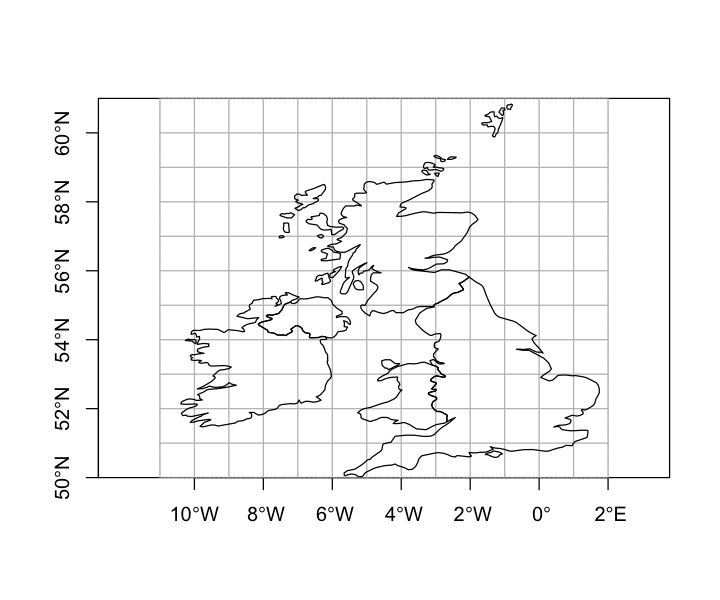

In [6]:
# Create a UK plot - code not seen by students
uk <- st_as_sf(ne_countries(
     country = c('united kingdom', 'ireland'), 
     scale = 'medium', 
     type='map_units')
)
lat_b <- 50; lat_t <- 61; lon_l <- -11; lon_r <- 2
lats <- seq(lat_b, lat_t, by=1)
lons <- seq(lon_l, lon_r, by=1)
plot(st_geometry(st_graticule(
          x=c(lon_l, lat_b, lon_r, lat_t), 
          crs=4326, lat=lats, lon=lons)),
     col='grey', xaxs='i', yaxs='i', asp=1, axes=TRUE)
plot(st_geometry(uk), add=TRUE)

In order to create vector data, we need to provide a set of coordinates for the points.
For different kinds of vector geometries (POINT, LINESTRING, POLYGON), the coordinates
are provided in different ways. Here, we are just using very simple polygons to show the
countries.

In [7]:
# Create coordinates  for each country 
# - this creates a matrix of pairs of coordinates forming the edge of the polygon. 
# - note that they have to _close_: the first and last coordinate must be the same.
scotland <- rbind(c(-5, 58.6), c(-3, 58.6), c(-4, 57.6), 
                  c(-1.5, 57.6), c(-2, 55.8), c(-3, 55), 
                  c(-5, 55), c(-6, 56), c(-5, 58.6))
england <- rbind(c(-2,55.8),c(0.5, 52.8), c(1.6, 52.8), 
                  c(0.7, 50.7), c(-5.7,50), c(-2.7, 51.5), 
                  c(-3, 53.4),c(-3, 55), c(-2,55.8))
wales <- rbind(c(-2.5, 51.3), c(-5.3,51.8), c(-4.5, 53.4),
                  c(-2.8, 53.4),  c(-2.5, 51.3))
ireland <- rbind(c(-10,51.5), c(-10, 54.2), c(-7.5, 55.3),
                  c(-5.9, 55.3), c(-5.9, 52.2), c(-10,51.5))

# Convert these coordinates into feature geometries
# - these are simple coordinate sets with no projection information
scotland <- st_polygon(list(scotland))
england <- st_polygon(list(england))
wales <- st_polygon(list(wales))
ireland <- st_polygon(list(ireland))

We can combine these into a **simple feature column** (`sfc`). This is a list of
geometries - below we will see how it is used to include vector data in a normal R
`data.frame` - but it is *also* used to set the coordinate reference system (`crs` or
projection) of the data. The mystery `4326` in the code below is explained later on!

One other thing to note here is that `sf` automatically tries to scale the aspect ratio
of plots of geographic coordinate data (coordinates are latitude and longitude) based on
their latitude - this makes them look less squashed. We are actively suppressing that
here by setting an aspect ratio of one (`asp=1`).

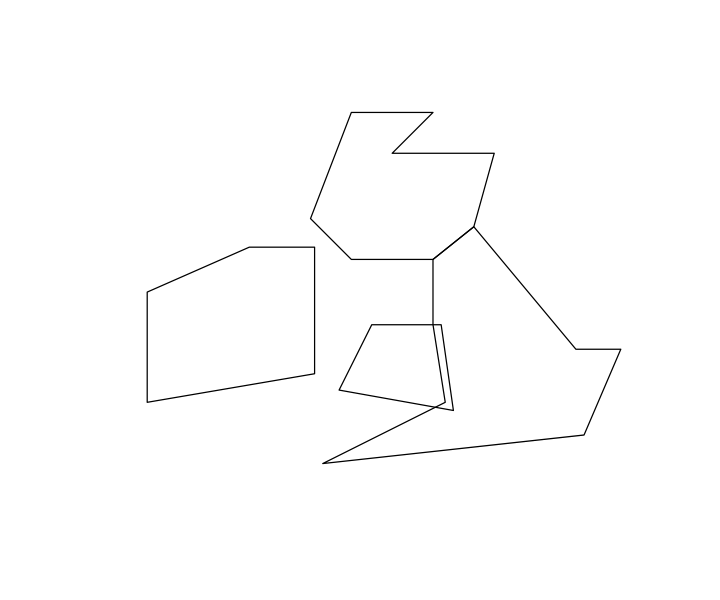

In [8]:
# Combine geometries into a simple feature column
uk_eire_sfc <- st_sfc(wales, england, scotland, ireland, crs=4326)
plot(uk_eire_sfc, asp=1)

### Making vector points from a dataframe

We can easily turn a data frame with coordinates in columns into a point vector data
source. The example here creates point locations for capital cities.

In [9]:
uk_eire_capitals <- data.frame(
     long= c(-0.1, -3.2, -3.2, -6.0, -6.25),
     lat=c(51.5, 51.5, 55.8, 54.6, 53.30),
     name=c('London', 'Cardiff', 'Edinburgh', 'Belfast', 'Dublin')
)

# Indicate which fields in the data frame contain the coordinates
uk_eire_capitals <- st_as_sf(uk_eire_capitals, coords=c('long','lat'), crs=4326)
print(uk_eire_capitals)

Simple feature collection with 5 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -6.25 ymin: 51.5 xmax: -0.1 ymax: 55.8
Geodetic CRS:  WGS 84
       name           geometry
1    London  POINT (-0.1 51.5)
2   Cardiff  POINT (-3.2 51.5)
3 Edinburgh  POINT (-3.2 55.8)
4   Belfast    POINT (-6 54.6)
5    Dublin POINT (-6.25 53.3)


### Vector geometry operations

That is a good start but we've got some issues:

1. We are missing a separate polygon for London.
1. The boundary for Wales is poorly digitized - we want a common border with England.
1. We have not separated Northern Ireland from Eire.

We'll handle those by using some geometry operations. First, we will use the **buffer**
operation to create a polygon for London, which we define as anywhere within a quarter
degree of St. Pauls Cathedral. This is a fairly stupid thing to do - we will come back
to why later.

In [10]:
st_pauls <- st_point(x=c(-0.098056, 51.513611))
london <- st_buffer(st_pauls, 0.25)

We also need to remove London from the England polygon so that we can set different
population densities for the two regions. This uses the **difference** operation. Note
that the order of the arguments to this function matter: we want the bits of England
that are different from London.

In [11]:
england_no_london <- st_difference(england, london)

Note that the resulting feature now has a different structure. The `lengths` function
allows us to see the number of components in a polygon and how many points are in each
component. If we look at the polygon for Scotland:

In [12]:
lengths(scotland)

[1] 18

There is a single component with 18 points. If we look at the new `england_no_london`
feature:

In [13]:
lengths(england_no_london)

[1]  18 242

There are **two** components (or rings): one ring for the 18 points along the external
border and a second ring of 242 points for the internal hole. Like `scotland`, all the
other un-holey polygons only contain a single ring for their external border.

We can use the same operation to tidy up Wales: in this case we want the bits of Wales
that are different from England.

In [14]:
wales <- st_difference(wales, england)

Now we will use the **intersection** operation to separate Northern Ireland from the
island of Ireland. First we create a rough polygon that includes Northern Ireland and
sticks out into the sea; then we find the intersection and difference of that with the
Ireland polygon to get Northern Ireland and Eire.

In [15]:
# A rough polygon that includes Northern Ireland and surrounding sea.
# - not the alternative way of providing the coordinates
ni_area <- st_polygon(list(cbind(x=c(-8.1, -6, -5, -6, -8.1), y=c(54.4, 56, 55, 54, 54.4))))

northern_ireland <- st_intersection(ireland, ni_area)
eire <- st_difference(ireland, ni_area)

# Combine the final geometries
uk_eire_sfc <- st_sfc(wales, england_no_london, scotland, london, northern_ireland, eire, crs=4326)

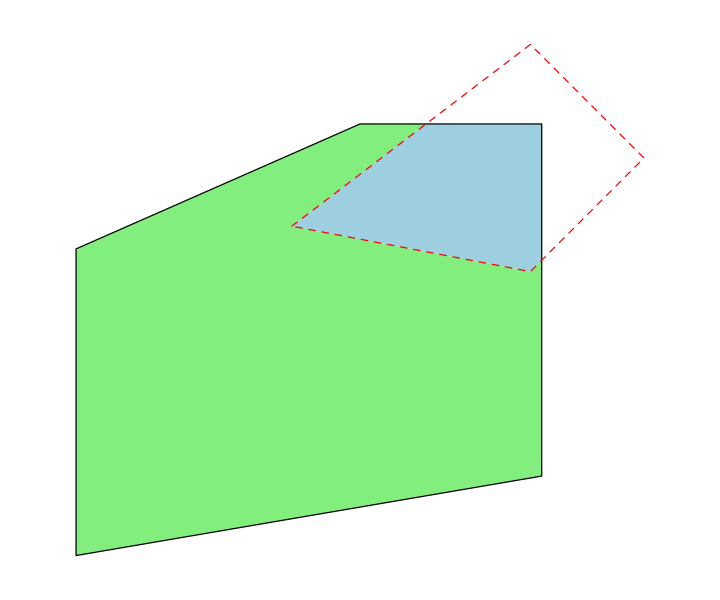

In [16]:
par( mar=c(1,1,1,1))
plot(northern_ireland, asp=1, ylim=c(51.5,56), 
     xlim=c(-10, -5),  col='lightblue', border=NA
)
plot(eire, add=TRUE, col='lightgreen', border=NA)
plot(ireland, add=TRUE)
plot(ni_area, add=TRUE, border='red', lty=2)

### Features and geometries

That `uk_eire_sfc` object now contains 6 **features**: a feature is a set of one or more
vector GIS geometries that represent a spatial unit we are interested in. At the moment,
`uk_eire_sfc` hold six features, each of which consists of a single polygon. The England
feature is slightly more complex because it as a hole in it. We can create a single
feature that contains all of those geometries in one `MULTIPOLYGON` geometry by using
the **union** operation:

In [17]:
# compare six Polygon features with one Multipolygon feature
print(uk_eire_sfc)

Geometry set for 6 features 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
Geodetic CRS:  WGS 84
First 5 geometries:


POLYGON ((-5.3 51.8, -4.5 53.4, -3 53.4, -2.7 5...



POLYGON ((0.5 52.8, 1.6 52.8, 0.7 50.7, -5.7 50...



POLYGON ((-5 58.6, -3 58.6, -4 57.6, -1.5 57.6,...



POLYGON ((0.151944 51.51361, 0.1516014 51.50053...



POLYGON ((-5.9 55.3, -5.9 54.1, -6 54, -8.1 54....



In [18]:
# make the UK into a single feature
uk_country <- st_union(uk_eire_sfc[-6])
print(uk_country)

although coordinates are longitude/latitude, st_union assumes that they are planar



Geometry set for 1 feature 
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -8.1 ymin: 50 xmax: 1.6 ymax: 58.6
Geodetic CRS:  WGS 84


MULTIPOLYGON (((-3 53.4, -3 55, -5 55, -6 56, -...



In [19]:
options(repr.plot.width=7, repr.plot.height= 3) # Change plot sizes (in cm)

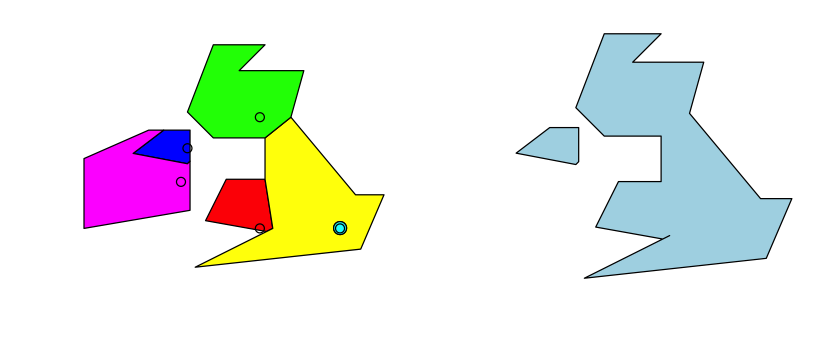

In [20]:
# Plot them
par(mfrow=c(1, 2), mar=c(3,3,1,1))
plot(uk_eire_sfc, asp=1, col=rainbow(6))
plot(st_geometry(uk_eire_capitals), add=TRUE)
plot(uk_country, asp=1, col='lightblue')

<!-- ## Geometry errors and validity

You can seen something odd about the `uk_country` map: it has a line at the southern end
of the Welsh border. It is a bit like the Severn estuary, but If you zoom in on that
area you would find it has basically zero width.

That isn't technically an error - it is just  that the vector processing is able to work
with arbitrarily small differences and has preserved these two parallel edges. We can
tidy it up by using a bit of a hack: buffer the whole feature by an arbitrarily small
amount.

```{r validity}
#st_is_valid(uk_country)
#uk_country <- st_buffer(uk_country, 0.000001)
```

However, sometimes geometries are not valid, for example

Zooming in and exploring GIS data is one of the things that R is currently poor at - you
are better off installing QGIS if you want to look over your data.
-->

### Vector data and attributes

So far we just have the vector geometries, but GIS data is about pairing spatial
features with data about those features, often called *attributes* or *properties*.

This kind of structure is basically just a type of data frame. A set of fields (or
columns) contain data for each location, and one of those fields is a geometry column
(the `sfc` object from before!) containing spatial data.

The `sf` package does this using the `sf` object type: basically this is just a normal
data frame with that additional field containing **simple feature** data. We can do that
here - printing the object shows some extra information compared to a basic
`data.frame`.

In [21]:
uk_eire_sf <- st_sf(name=c('Wales', 'England','Scotland', 'London', 
                        'Northern Ireland', 'Eire'),
                    geometry=uk_eire_sfc)

print(uk_eire_sf)

Simple feature collection with 6 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
Geodetic CRS:  WGS 84
              name                       geometry
1            Wales POLYGON ((-5.3 51.8, -4.5 5...
2          England POLYGON ((0.5 52.8, 1.6 52....
3         Scotland POLYGON ((-5 58.6, -3 58.6,...
4           London POLYGON ((0.151944 51.51361...
5 Northern Ireland POLYGON ((-5.9 55.3, -5.9 5...
6             Eire POLYGON ((-10 54.2, -7.5 55...


An `sf` object also has a simple `plot` method, which we can use to draw a basic map. We
will come back to making maps look better later on.

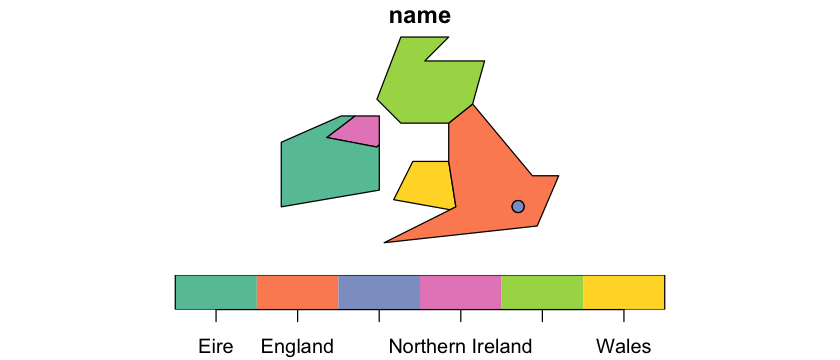

In [22]:
plot(uk_eire_sf['name'], asp=1)

Since an `sf` object is an extended data frame, we can add attributes by adding fields
directly:

In [23]:
uk_eire_sf$capital <- c('Cardiff', 'London', 'Edinburgh', 
                        NA, 'Belfast','Dublin')
print(uk_eire_sf)

Simple feature collection with 6 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
Geodetic CRS:  WGS 84
              name                       geometry   capital
1            Wales POLYGON ((-5.3 51.8, -4.5 5...   Cardiff
2          England POLYGON ((0.5 52.8, 1.6 52....    London
3         Scotland POLYGON ((-5 58.6, -3 58.6,... Edinburgh
4           London POLYGON ((0.151944 51.51361...      <NA>
5 Northern Ireland POLYGON ((-5.9 55.3, -5.9 5...   Belfast
6             Eire POLYGON ((-10 54.2, -7.5 55...    Dublin


A more useful - and less error prone - technique to add data to a data frame is to use
the `merge` command to match data in from the `pop_dens` data frame. The `merge`
function allows us to set columns in two data frames that containing matching values and
uses those to merge the data together.

- We need to use `by.x` and `by.y` to say which columns we expect to match, but if the
  column names were identical in the two frames, we could just use `by`.
- The default for `merge` is to drop rows when it doesn't find matching data. So here,
  we have to also use `all.x=TRUE`, otherwise Eire will be dropped from the spatial data
  because it has no population density estimate in the data frame.

If we look at the result, we get some header information about the spatial data and then
something that looks very like a data frame printout, with the extra `geometry` column.

In [24]:
uk_eire_sf <- merge(uk_eire_sf, pop_dens, by.x='name', by.y='country', all.x=TRUE)
print(uk_eire_sf)

Simple feature collection with 6 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
Geodetic CRS:  WGS 84
              name   capital n_km2                       geometry
1             Eire    Dublin    NA POLYGON ((-10 54.2, -7.5 55...
2          England    London   260 POLYGON ((0.5 52.8, 1.6 52....
3           London      <NA>  4500 POLYGON ((0.151944 51.51361...
4 Northern Ireland   Belfast   133 POLYGON ((-5.9 55.3, -5.9 5...
5         Scotland Edinburgh    67 POLYGON ((-5 58.6, -3 58.6,...
6            Wales   Cardiff   151 POLYGON ((-5.3 51.8, -4.5 5...


### Spatial attributes

One common thing that people want to know are spatial attributes of geometries and there
are a range of commands to find these things out. One thing we might want are the
**centroids** of features.

In [25]:
st_agr(uk_eire_sf) <- 'constant'

In [26]:
uk_eire_centroids <- st_centroid(uk_eire_sf)
st_coordinates(uk_eire_centroids)

Warning message in st_centroid.sfc(st_geometry(x), of_largest_polygon = of_largest_polygon):
“st_centroid does not give correct centroids for longitude/latitude data”


X         Y       
1 -8.102211 53.20399
2 -1.479850 52.43729
3 -0.098056 51.51361
4 -6.717310 54.66788
5 -3.867713 56.65262
6 -3.854234 52.39819

Two other simple ones are the **length** of a feature and its **area**. Note that here
`sf` is able to do something clever behind the scenes. Rather than give us answers in
units of degrees, it notes that we have a goegraphic coordinate system and instead uses
internal transformations to give us back accurate distances and areas using metres.
Under the hood, it is using calculations on the surface of a sphere, so called
[great circle distances](https://en.wikipedia.org/wiki/Great-circle_distance).

In [27]:
uk_eire_sf$area <- st_area(uk_eire_sf)

# To calculate a 'length' of a polygon, you have to convert it to a LINESTRING or a 
# MULTILINESTRING. Using MULTILINESTRING will automatically include all perimeter of a 
# polygon (including holes).
uk_eire_sf$length <- st_length(st_cast(uk_eire_sf, 'MULTILINESTRING'))

# Look at the result
print(uk_eire_sf)

Simple feature collection with 6 features and 5 fields
Attribute-geometry relationship: 3 constant, 0 aggregate, 0 identity, 2 NA's
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
Geodetic CRS:  WGS 84
              name   capital n_km2                       geometry
1             Eire    Dublin    NA POLYGON ((-10 54.2, -7.5 55...
2          England    London   260 POLYGON ((0.5 52.8, 1.6 52....
3           London      <NA>  4500 POLYGON ((0.151944 51.51361...
4 Northern Ireland   Belfast   133 POLYGON ((-5.9 55.3, -5.9 5...
5         Scotland Edinburgh    67 POLYGON ((-5 58.6, -3 58.6,...
6            Wales   Cardiff   151 POLYGON ((-5.3 51.8, -4.5 5...
                area        length
1  80555367364 [m^2] 1326763.9 [m]
2 125982254516 [m^2] 2062484.3 [m]
3   1515812620 [m^2]  143796.2 [m]
4  13656055128 [m^2]  480968.2 [m]
5  76276260910 [m^2] 1255577.2 [m]
6  28948401464 [m^2]  689831.5 [m]


Notice that those fields display units after the values. The `sf` package often creates
data with explicit units, using the `units` package. You do need to know some extra
commands to handle these fields:

In [28]:
# You can change units in a neat way
uk_eire_sf$area <- set_units(uk_eire_sf$area, 'km^2')
uk_eire_sf$length <- set_units(uk_eire_sf$length, 'km')
print(uk_eire_sf)

Simple feature collection with 6 features and 5 fields
Attribute-geometry relationship: 3 constant, 0 aggregate, 0 identity, 2 NA's
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
Geodetic CRS:  WGS 84
              name   capital n_km2                       geometry
1             Eire    Dublin    NA POLYGON ((-10 54.2, -7.5 55...
2          England    London   260 POLYGON ((0.5 52.8, 1.6 52....
3           London      <NA>  4500 POLYGON ((0.151944 51.51361...
4 Northern Ireland   Belfast   133 POLYGON ((-5.9 55.3, -5.9 5...
5         Scotland Edinburgh    67 POLYGON ((-5 58.6, -3 58.6,...
6            Wales   Cardiff   151 POLYGON ((-5.3 51.8, -4.5 5...
               area         length
1  80555.367 [km^2] 1326.7639 [km]
2 125982.255 [km^2] 2062.4843 [km]
3   1515.813 [km^2]  143.7962 [km]
4  13656.055 [km^2]  480.9682 [km]
5  76276.261 [km^2] 1255.5772 [km]
6  28948.401 [km^2]  689.8315 [km]


In [29]:
# And it won't let you make silly error like turning a length into weight
uk_eire_sf$area <- set_units(uk_eire_sf$area, 'kg')

ERROR: Error: cannot convert km^2 into kg


In [30]:
# Or you can simply convert the `units` version to simple numbers
uk_eire_sf$length <- as.numeric(uk_eire_sf$length)

A final useful example is the **distance** between objects: `sf` gives us the closest
distance between geometries, which might be zero if two features overlap or touch, as in
the neighbouring polygons in our data.

In [31]:
st_distance(uk_eire_sf)

Units: [m]
          [,1]     [,2]     [,3]      [,4]      [,5]      [,6]
[1,]      0.00 189660.5 388874.5      0.00  89305.75  52085.08
[2,] 189660.51      0.0      0.0 185529.79      0.00      0.00
[3,] 388874.46      0.0      0.0 463253.57 407423.19 163295.88
[4,]      0.00 185529.8 463253.6      0.00  33455.33 119471.08
[5,]  89305.75      0.0 407423.2  33455.33      0.00 178084.13
[6,]  52085.08      0.0 163295.9 119471.08 178084.13      0.00

In [32]:
st_distance(uk_eire_centroids)

Units: [m]
         [,1]     [,2]     [,3]     [,4]     [,5]     [,6]
[1,]      0.0 454351.6 576456.5 186596.2 469999.3 300157.7
[2,] 454351.6      0.0 139917.3 426582.5 493943.0 161597.1
[3,] 576456.5 139917.3      0.0 565182.7 622706.0 276301.1
[4,] 186596.2 426582.5 565182.7      0.0 284546.5 315936.9
[5,] 469999.3 493943.0 622706.0 284546.5      0.0 473581.0
[6,] 300157.7 161597.1 276301.1 315936.9 473581.0      0.0

Again, `sf` is noting that we have a geographic coordinate system and internally
calculating distances in metres.

### Plotting `sf` objects

If you plot an `sf` object, the default is to plot a map for every attribute, but you
can pick a single field to plot by using square brackets. So, now we can show our map of
population density:

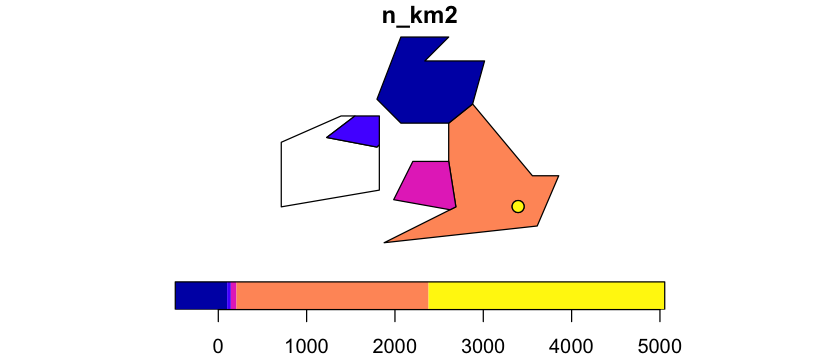

In [33]:
plot(uk_eire_sf['n_km2'], asp=1)

If you just want to plot the geometries, without any labelling or colours, the
`st_geometry` function can be used to temporarily strip off attributes - see the
reprojection section below for an example.

```{admonition} Scale the legend

The scale on that plot isn't very helpful. Look at `?plot.sf` and see if you can get a
log scale on the right.
```

In [34]:
options(repr.plot.width=7, repr.plot.height= 6) # Change plot sizes (in cm)

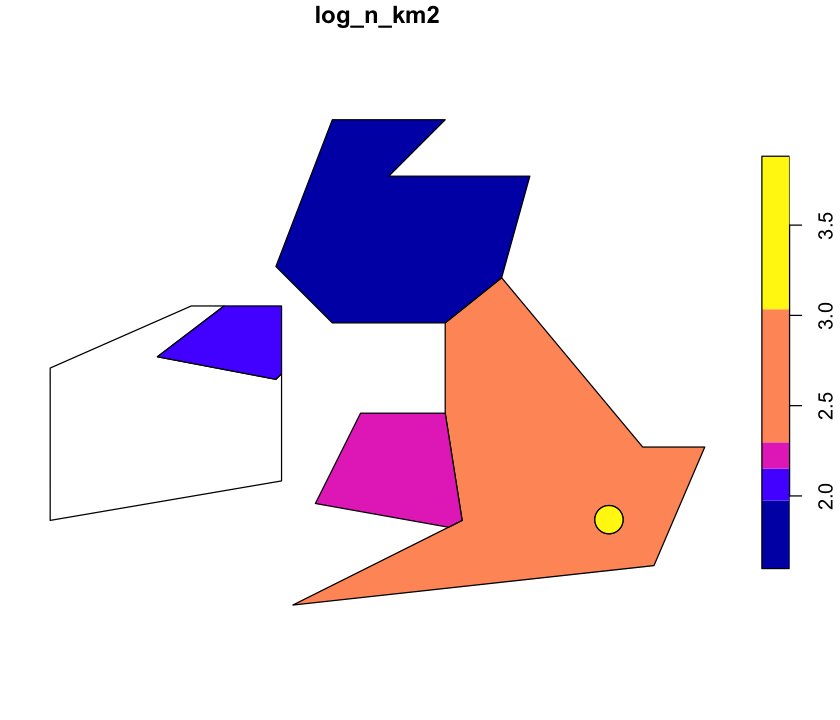

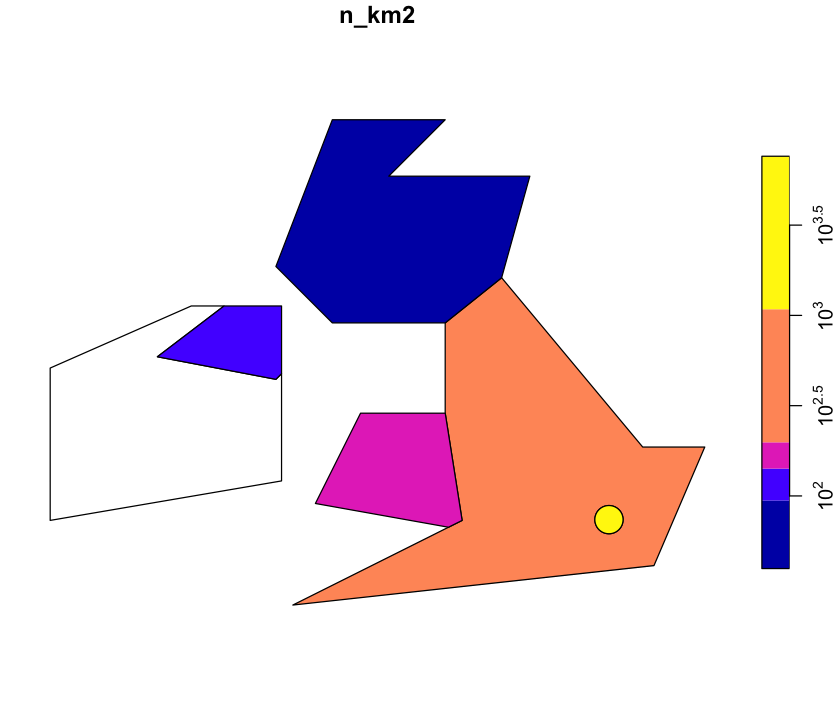

In [35]:

# You could simply log the data:
uk_eire_sf$log_n_km2 <- log10(uk_eire_sf$n_km2)
plot(uk_eire_sf['log_n_km2'], asp=1, key.pos=4)
# Or you can have logarithimic labelling using logz
plot(uk_eire_sf['n_km2'], asp=1, logz=TRUE, key.pos=4)

### Reprojecting vector data

First, in the examples above we have been **asserting** that we have data with a
particular projection (`4326`). This is **not reprojection**: we are simply saying that
we know these coordinates are in this projection and setting that projection.

That mysterious `4326` is just a unique numeric code in the EPSG database of spatial
coordinate systems: [http://epsg.io/](http://epsg.io/). The code acts a shortcut for the
often complicated sets of parameters that define a particular projection. Here `4326` is
the [WGS84](http://epsg.io/4326) geographic coordinate system which is extremely widely
used. Most GPS data is collected in WGS84, for example.

The process of **reprojection** is different: it involves transforming data from one set
of coordinates to another. For vector data, this is a relatively straightforward
process. The spatial information in a vector dataset are coordinates in space, and
projections are just sets of equations, so it is simple to apply the equations to the
coordinates. We'll come back to this for raster data: coordinate transformation is
identical but transforming the data stored in a raster is conceptually more complex.

Reprojecting data is often used to convert from a geographic coordinate system - with
units of degrees - to a projected coordinate system with linear units. Remember that
projected coordinate systems are always a trade off between conserving distance, shape,
area and bearings and it is important to pick one that is appropriate to your area or
analysis.

We will reproject our UK and Eire map onto a good choice of local projected coordinate
system: the [British National Grid](http://epsg.io/27700). We can also use a bad choice:
the [UTM 50N](http://epsg.io/32650) projection, which is appropriate for Borneo. It does
not end well if we use it to project the UK and Eire.

In [36]:
# British National Grid (EPSG:27700)
uk_eire_BNG <- st_transform(uk_eire_sf, 27700)
# UTM50N (EPSG:32650)
uk_eire_UTM50N <- st_transform(uk_eire_sf, 32650)
# The bounding boxes of the data shows the change in units
st_bbox(uk_eire_sf)

 xmin  ymin  xmax  ymax 
-10.0  50.0   1.6  58.6 

In [37]:
st_bbox(uk_eire_BNG)

      xmin       ymin       xmax       ymax 
-154839.00   17656.53  642772.42  971902.51 

We can then plot these data side by side to see the effects on the shape and orientation
of the data and the scaling on the axes. Note here, we are using the `st_geometry`
function to *only* plot the geometry data and not a particular attribute. The UTM50N
projection is **not** a suitable choice for the UK!

In [38]:
options(repr.plot.width=12, repr.plot.height= 6) # Change plot sizes (in cm)

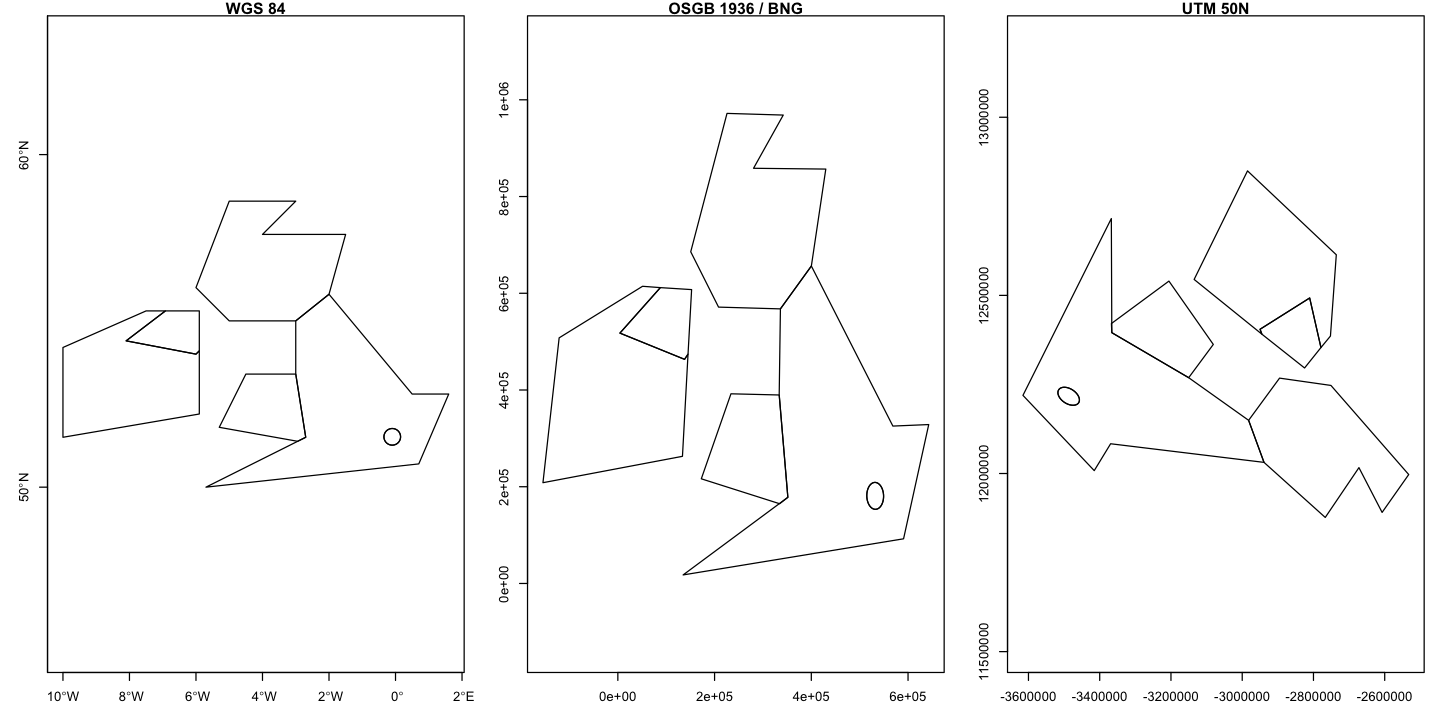

In [39]:
# Plot the results
par(mfrow=c(1, 3), mar=c(3,3,1,1))
plot(st_geometry(uk_eire_sf), asp=1, axes=TRUE, main='WGS 84')
plot(st_geometry(uk_eire_BNG), axes=TRUE, main='OSGB 1936 / BNG')
plot(st_geometry(uk_eire_UTM50N), axes=TRUE, main='UTM 50N')

#### Proj4 strings

Those EPSG ID codes save us from `proj4` strings (see [here](https://proj.org/)): these
text strings contain often long and confusing sets of options and parameters that
actually define a particular projection. The `sf` package is kind to us, but some other
packages are not, so you may see these in R and you can also see the `proj4` strings on
the EPSG website:

- **4326**:
  `+init=EPSG:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0`
- **27700**:
  `+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000+ellps=airy`\
  `+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs`
- **32650**: `+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs`

#### Degrees are not constant

The units of geographic coordinate systems are **angles** of latitide and longitude.
These are not a constant unit of distance and as lines of longitude converge towards to
pole, the physical length of a degree decreases. This is why our decision to use a 0.25°
buffered point for London is a poor choice and why it is distorted in the BNG map.

At the latitude of London, a degree longitude is about 69km and a degree latitude is
about 111 km. Again `st_distance` is noting that we have geographic coordinates and is
returning great circle distances in metres.

In [40]:
# Set up some points separated by 1 degree latitude and longitude from St. Pauls
st_pauls <- st_sfc(st_pauls, crs=4326)
one_deg_west_pt <- st_sfc(st_pauls - c(1, 0), crs=4326) # near Goring
one_deg_north_pt <-  st_sfc(st_pauls + c(0, 1), crs=4326) # near Peterborough
# Calculate the distance between St Pauls and each point
st_distance(st_pauls, one_deg_west_pt)

Units: [m]
         [,1]
[1,] 69419.29

In [41]:
st_distance(st_pauls, one_deg_north_pt)

Units: [m]
         [,1]
[1,] 111267.6

Note that the great circle distance between London and Goring is different from the
distance between the same coordinates projected onto the British National Grid. Either
the WGS84 global model is locally imprecise or the BNG projection contains some distance
distortions: probably both!

In [42]:
st_distance(st_transform(st_pauls, 27700), 
            st_transform(one_deg_west_pt, 27700))

Units: [m]
         [,1]
[1,] 69401.61

```{admonition} Improve the London feature

Our feature for London would be far better if it used a constant 25km buffer around St.
Pauls, rather than the poor atttempt using degrees. The resulting map is below - try to
recreate it.
```

In [43]:
options(repr.plot.width=6, repr.plot.height= 6) # Change plot sizes (in cm)

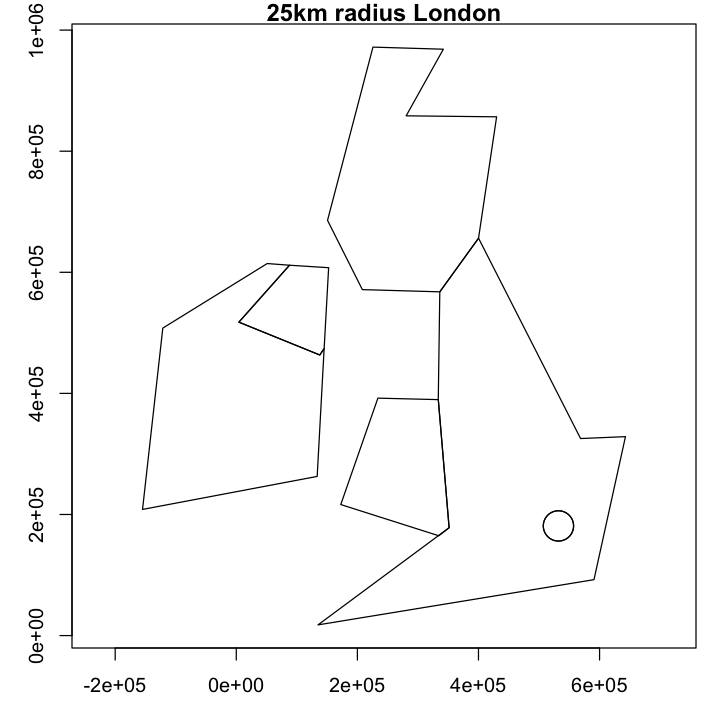

In [44]:
# transform St Pauls to BNG and buffer using 25 km
london_bng <- st_buffer(st_transform(st_pauls, 27700), 25000)
# In one line, transform england to BNG and cut out London
england_not_london_bng <- st_difference(st_transform(st_sfc(england, crs=4326), 27700), london_bng)
# project the other features and combine everything together
others_bng <- st_transform(st_sfc(eire, northern_ireland, scotland, wales, crs=4326), 27700)
corrected <- c(others_bng, london_bng, england_not_london_bng)
# Plot that and marvel at the nice circular feature around London
par(mar=c(3,3,1,1))
plot(corrected, main='25km radius London', axes=TRUE)

## Rasters

Rasters are the other major type of spatial data. They consist of a regular grid in
space, defined by a coordinate system, an origin point, a resolution and a number of
rows and columns. They effectively hold a matrix of data. We will use the `terra`
package to handle raster data - this is relatively new and replaces the older `raster`
package. The `terra` website has fantastic documentation:
[https://rspatial.org/terra](https://rspatial.org/terra).

### Creating a raster

We are first going to build a simple raster dataset from scratch. We are setting the
projection, the bounds and the resolution. The raster object (which has the `SpatRaster`
class) initially has no data values associated with it, but we can then add data.

Note that the `terra` package doesn't support using EPSG codes as numbers, but does
support them as a formatted text string: `EPSG:4326`.

In [45]:
# Create an empty raster object covering UK and Eire
uk_raster_WGS84 <- rast(xmin=-11,  xmax=2,  ymin=49.5, ymax=59, 
                        res=0.5, crs="EPSG:4326")
hasValues(uk_raster_WGS84)

[1] FALSE

In [46]:
# Add data to the raster - just use the cell numbers
values(uk_raster_WGS84) <- cells(uk_raster_WGS84)
print(uk_raster_WGS84)

class       : SpatRaster 
dimensions  : 19, 26, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -11, 2, 49.5, 59  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : memory 
name        : lyr.1 
min value   :     1 
max value   :   494 


We can create a basic map of that, with the country borders over the top: `add=TRUE`
adds the vector data to the existing map and the other options set border and fill
colours. The ugly looking `#FFFFFF44` is a
[RGBA colour code](<https://en.wikipedia.org/wiki/RGBA_color_space#RGBA_hexadecimal_(word-order)>)
that gives us a transparent gray fill for the polygon.

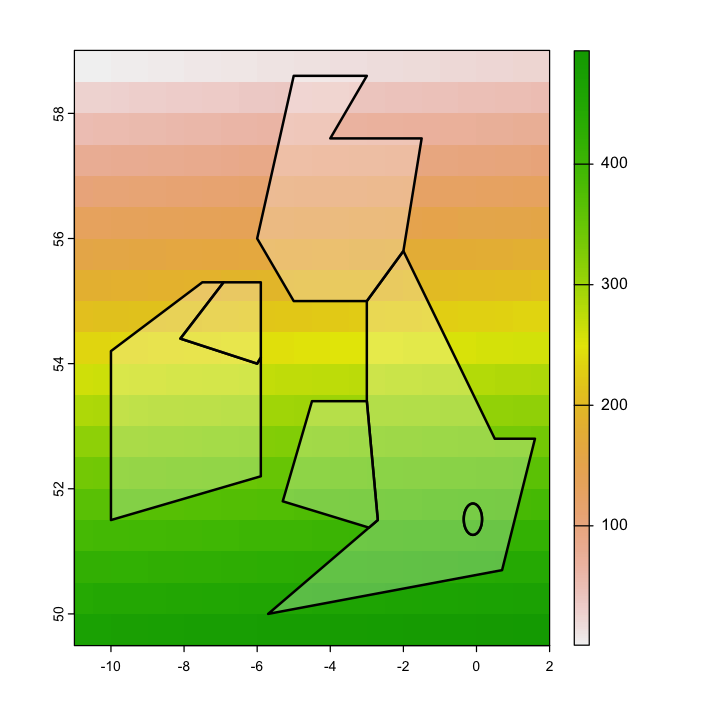

In [47]:
plot(uk_raster_WGS84)
plot(st_geometry(uk_eire_sf), add=TRUE, border='black', lwd=2, col='#FFFFFF44')

### Changing raster resolution

You can change a raster to have either coarser or finer resolution, but you have to
**think** about what the data is and what it means when you *aggregate* or
*disaggregate* the values. You might need to do this to make different data sources have
the same resolution for an analysis, or because the data you are using is more detailed
than you need or can analyse.

To show this, we will just use a simple matrix of values (raster data is just a matrix)
because it is easier to show the calculations.

In [48]:
options(repr.plot.width=4, repr.plot.height= 4) # Change plot sizes (in cm)

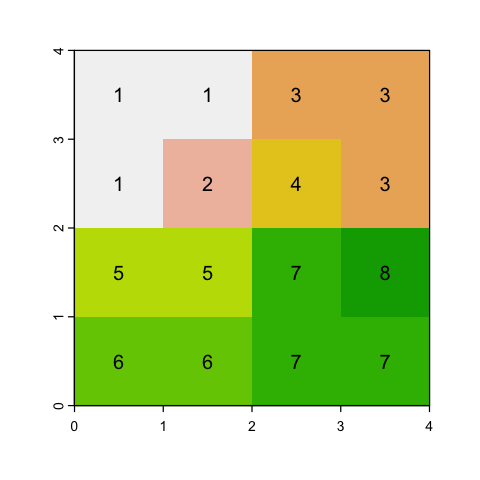

In [49]:
# Define a simple 4 x 4 square raster
m <- matrix(c(1, 1, 3, 3,
              1, 2, 4, 3,
              5, 5, 7, 8,
              6, 6, 7, 7), ncol=4, byrow=TRUE)
square <- rast(m)

plot(square, legend=NULL)
text(square, digits=2)

### Aggregating rasters

With aggregating, we choose an aggregation *factor* - how many cells to group - and then
lump sets of cells together. So, for example, a factor of 2 will aggregate blocks of 2x2
cells.

The question is then, what value should we assign? If the data is continuous (e.g.
height) then a mean or a maximum might make sense. However if the raster values
represent categories (like land cover), then mean doesn't make sense *at all*: the
average of Forest (2) and Moorland (3) codes is easy to calculate but is meaningless!

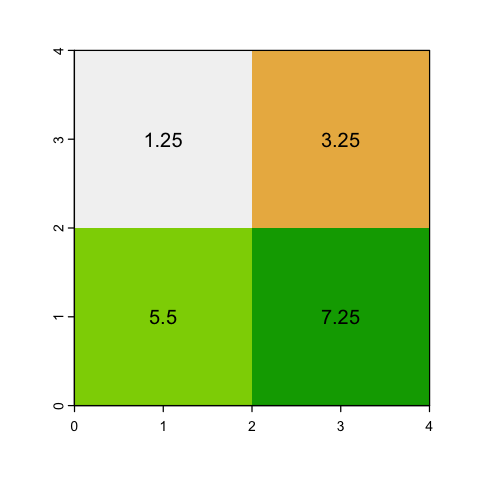

In [50]:
# Average values
square_agg_mean <- aggregate(square, fact=2, fun=mean)
plot(square_agg_mean, legend=NULL)
text(square_agg_mean, digits=2)

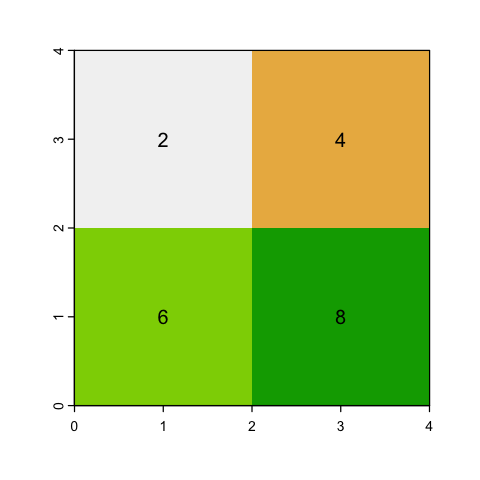

In [51]:
# Maximum values
square_agg_max <- aggregate(square, fact=2, fun=max)
plot(square_agg_max, legend=NULL)
text(square_agg_max, digits=2)

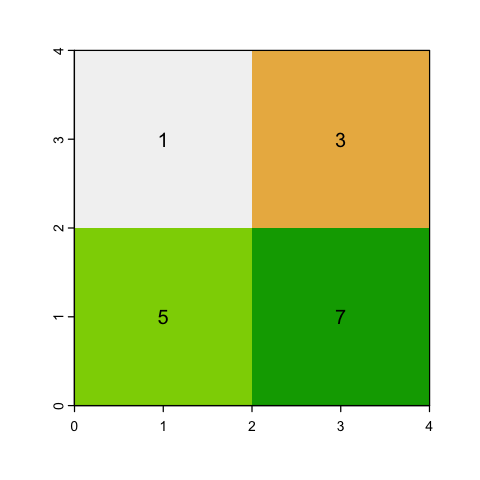

In [52]:
# Modal values for categories
square_agg_modal <- aggregate(square, fact=2, fun='modal')
plot(square_agg_modal, legend=NULL)
text(square_agg_modal, digits=2)

```{admonition} Issues with aggregation
Even using the modal value, there is a problem with aggregating rasters with categories.
This occurs in the example data - can you see what it is?
```

```{toggle}
The bottom left cell has a modal value of 5 even though there is no mode: there are two
5s and two 6s. You can use `first` and `last` to specify which value gets chosen but 
strictly there is no single mode.
```

### Disaggregating rasters

The `disaggregate` function also requires a factor, but this time the factor is the
square root of the number of cells to *create* from each cell, rather than the number to
merge. There is again a choice to make on what values to put in the cell. The obvious
answer is simply to copy the nearest parent cell value into each of the new cells: this
is pretty simple and is fine for both continuous and categorical values.

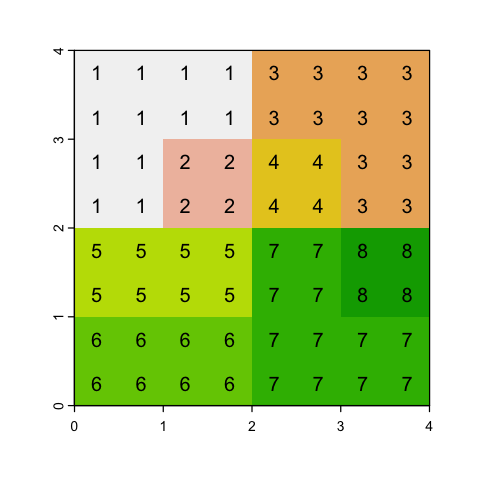

In [53]:
# Simply duplicate the nearest parent value
square_disagg <- disagg(square, fact=2, method='near')
plot(square_disagg, legend=NULL)
text(square_disagg, digits=2)

Another option is to **interpolate** between the values to provide a smoother gradient
between cells. This does **not** make sense for a categorical variable.

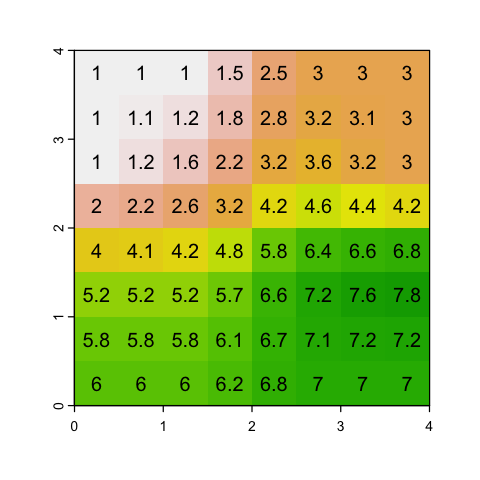

In [54]:
# Use bilinear interpolation
square_interp <- disagg(square, fact=2, method='bilinear')
plot(square_interp, legend=NULL)
text(square_interp, digits=1)

### Resampling

Note that the previous two functions don't change the **origin** or **alignments of cell
borders** at all: they just lump or split the existing values within the same cell
boundaries.

However you can easily end up with two raster data sets that have the **same
projection** but different origins and resolutions, giving different cell boundaries.
These data do not overlie each other and often need to be aligned to be be used
together.

If you need to match datasets and they have different origins and alignments then you
need to use the more complex `resample` function. We won't look at this further here
because it is basically a simpler case of ...

### Reprojecting a raster

This is conceptually more difficult than reprojecting vector data but we've covered the
main reasons above. You have a series of raster cell values in one projection and then
want to insert representative values into a set of cells on a different projection. The
borders of those new cells could have all sorts of odd relationships to the current
ones.

In the example here, we are show how our 0.5° WGS84 raster for the UK and Eire compares
to a 100km resolution raster on the British National Grid.

We can't display that using actual raster data because they always need to plot on a
regular grid. However we can create vector grids, using the new function `st_make_grid`
and our other vector tools, to represent the cell edges in the two raster grids so we
can overplot them. You can see how transferring cell values between those two raster
grids gets complicated!

In [55]:
options(repr.plot.width=8, repr.plot.height= 5) # Change plot sizes (in cm)

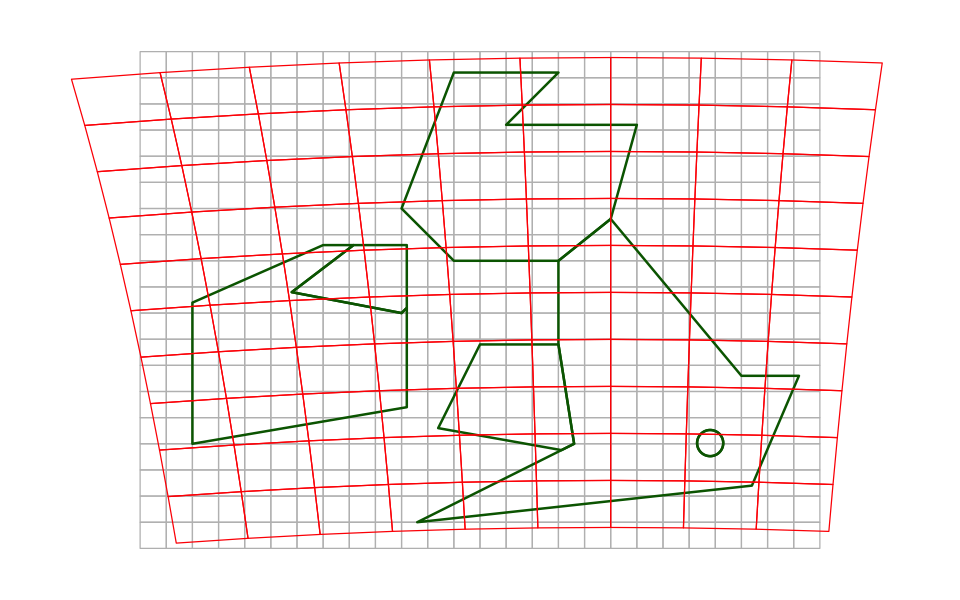

In [56]:
# make two simple `sfc` objects containing points in  the
# lower left and top right of the two grids
uk_pts_WGS84 <- st_sfc(st_point(c(-11, 49.5)), st_point(c(2, 59)), crs=4326)
uk_pts_BNG <- st_sfc(st_point(c(-2e5, 0)), st_point(c(7e5, 1e6)), crs=27700)

#  Use st_make_grid to quickly create a polygon grid with the right cellsize
uk_grid_WGS84 <- st_make_grid(uk_pts_WGS84, cellsize=0.5)
uk_grid_BNG <- st_make_grid(uk_pts_BNG, cellsize=1e5)

# Reproject BNG grid into WGS84
uk_grid_BNG_as_WGS84 <- st_transform(uk_grid_BNG, 4326)

# Plot the features
par(mar=c(0,0,0,0))
plot(uk_grid_WGS84, asp=1, border='grey', xlim=c(-13,4))
plot(st_geometry(uk_eire_sf), add=TRUE, border='darkgreen', lwd=2)
plot(uk_grid_BNG_as_WGS84, border='red', add=TRUE)

We will use the `project` function, which gives us the choice of interpolating a
representative value from the source data (`method='bilinear'`) or picking the cell
value from the nearest neighbour to the new cell centre (`method='near'`). We first
create the target raster - we don't have to put any data into it - and use that as a
template for the reprojected data.

In [57]:
# Create the target raster
uk_raster_BNG <- rast(xmin=-200000, xmax=700000, ymin=0, ymax=1000000,
                      res=100000, crs='+init=EPSG:27700')
uk_raster_BNG_interp <- project(uk_raster_WGS84, uk_raster_BNG, method='bilinear')
uk_raster_BNG_near <- project(uk_raster_WGS84, uk_raster_BNG, method='near')

When we plot those data:

- There are missing values in the top right and left. In the plot above, you can see
  that the centres of those red cells do not overlie the original grey grid and
  `project` has not assigned values.
- You can see the more abrupt changes when using nearest neighbour reprojection.

In [58]:
options(repr.plot.width=12, repr.plot.height= 8) # Change plot sizes (in cm)

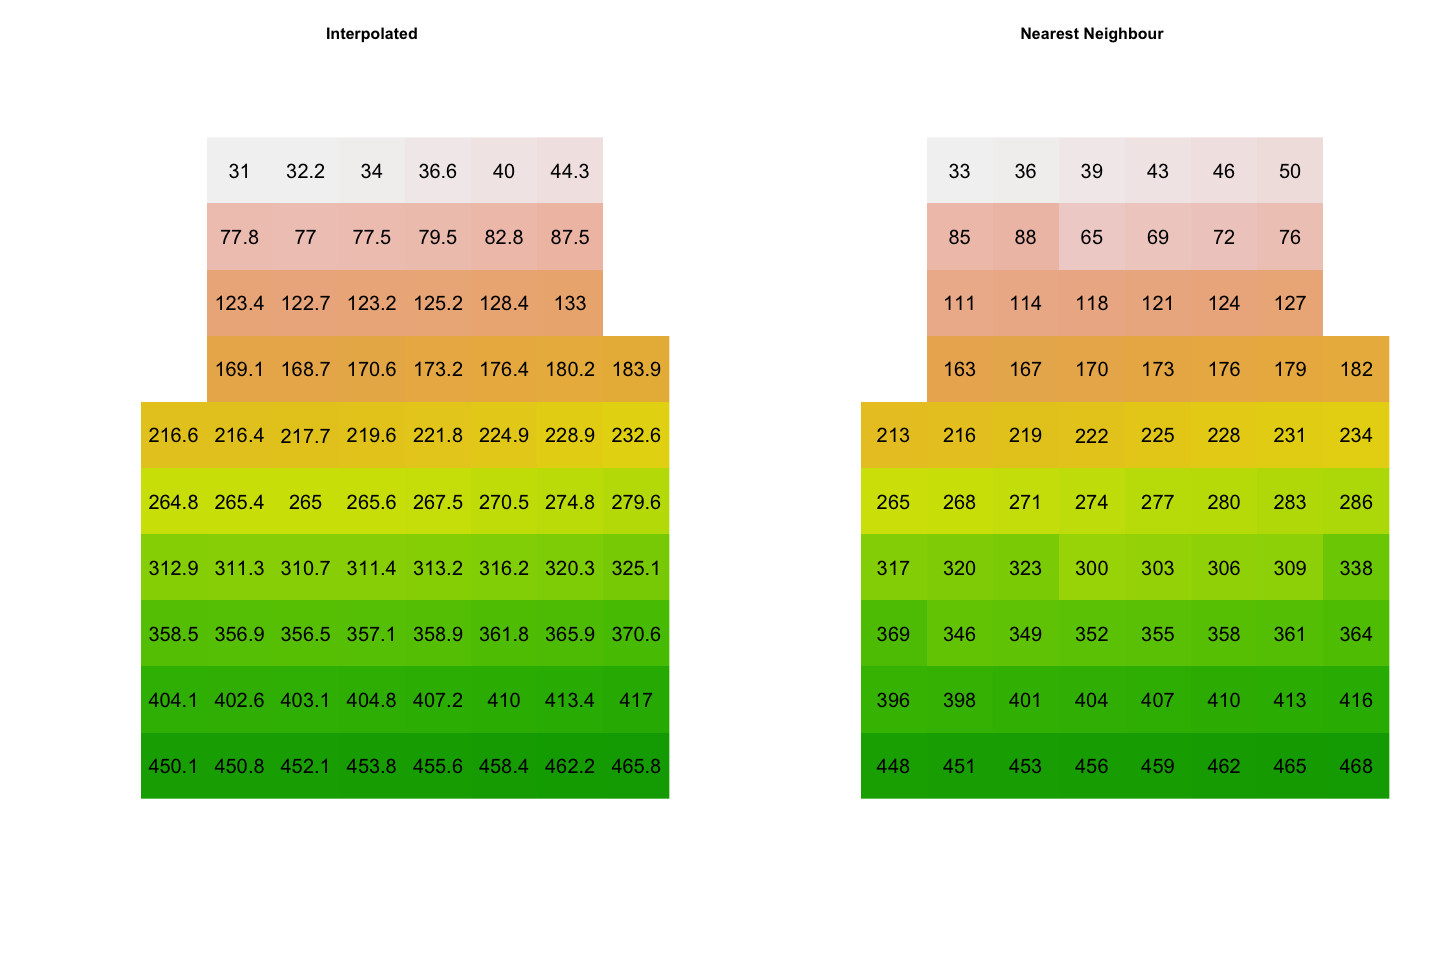

In [59]:
par(mfrow=c(1,2), mar=c(0,0,0,0))
plot(uk_raster_BNG_interp, main='Interpolated', axes=FALSE, legend=FALSE)
text(uk_raster_BNG_interp, digit=1)
plot(uk_raster_BNG_near, main='Nearest Neighbour',axes=FALSE, legend=FALSE)
text(uk_raster_BNG_near)

## Converting between vector and raster data types

Sometimes you want to represent raster data in vector format or vice versa. It is
usually worth thinking if you really want to do this - data usually comes in one format
or another for a reason - but there are plenty of valid reasons to do it.

### Vector to raster

Converting vector data to a raster is a bit like `reprojectRaster`: you provide the
target raster and the vector data and put it all through the `rasterize` function. There
are important differences in the way that different geometry types get rasterized. In
each case, a vector attribute is chosen to assign cell values in ther raster.

- **POINT**: If a point falls anywhere within a cell, that value is assigned to the
  cell.
- **LINESTRING**: If any part of the linestring falls within a cell, that value is
  assigned to the cell.
- **POLYGON**: If the centre of the cell falls within a polygon, the value from that
  polygon is assigned to the cell.

It is common that a cell might have more than one possible value - for example if two
points fall in a cell. The `rasterize` function has a `fun` argument that allows you to
set rules to decide which value 'wins'.

We'll rasterize the `uk_eire_BNG` vector data onto a 20km resolution grid.

In [60]:
options(repr.plot.width=7, repr.plot.height= 7) # Change plot sizes (in cm)

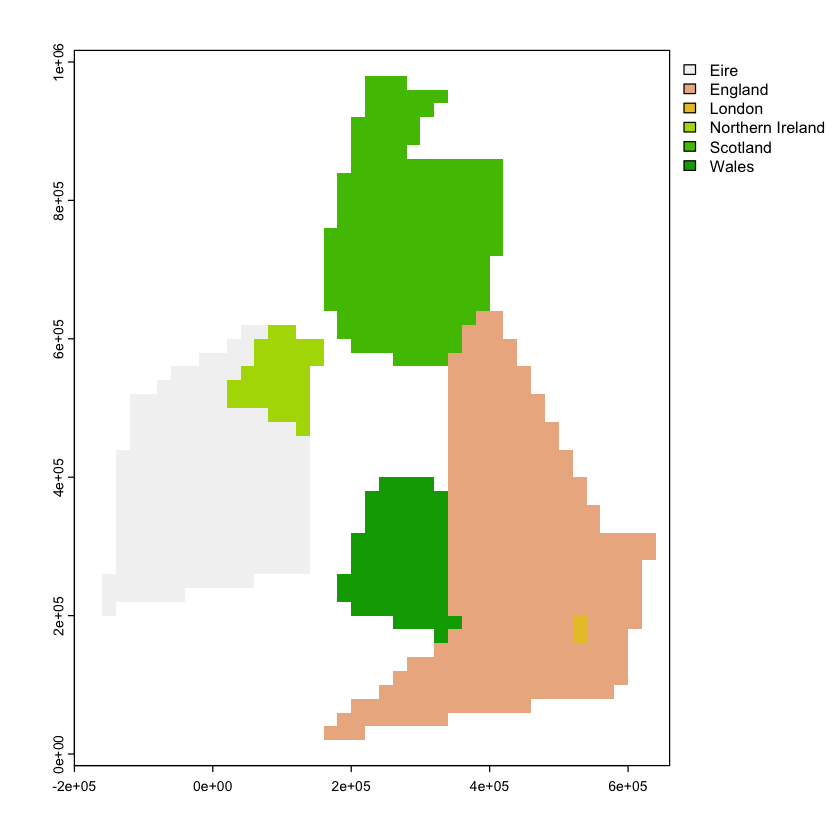

In [61]:
# Create the target raster 
uk_20km <- rast(xmin=-200000, xmax=650000, ymin=0, ymax=1000000, 
                res=20000, crs='+init=EPSG:27700')

# Rasterizing polygons
uk_eire_poly_20km  <- rasterize(uk_eire_BNG, uk_20km, field='name')

plot(uk_eire_poly_20km)

Getting raster versions of polygons is *by far* the most common use case, but it is also
possible to represent the boundary lines or even the polygon vertices as raster data.

To do that, we have to **recast** the polygon data, so that the rasterisation process
knows to treat the data differently: the list of polygon vertices no longer form a
closed loop (a polygon), but form a linear feature or a set of points.

Before we do that, one excellent feature of the `sf` package is the sheer quantity of
warnings it will issue to avoid making errors. When you alter geometries, it isn't
always clear that the attributes of the original geometry apply to the altered
geometries. We can use the `st_agr` function to tell `sf` that attributes *are* constant
and it will stop warning us.

In [62]:
options(repr.plot.width=12, repr.plot.height= 4) # Change plot sizes (in cm)

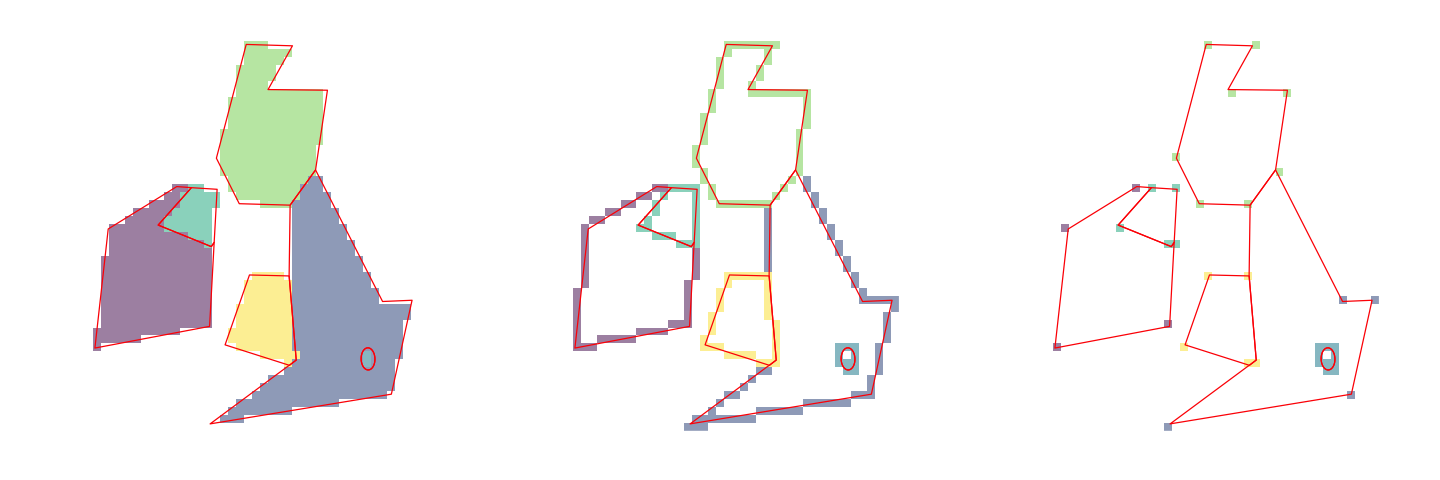

In [63]:
uk_eire_BNG$name <- as.factor(uk_eire_BNG$name)
st_agr(uk_eire_BNG) <- 'constant'

# Rasterizing lines.
uk_eire_BNG_line <- st_cast(uk_eire_BNG, 'LINESTRING')
uk_eire_line_20km <- rasterize(uk_eire_BNG_line, uk_20km, field='name')

# Rasterizing points 
# - This isn't quite as neat as there are two steps in the casting process:
#   Polygon -> Multipoint -> Point
uk_eire_BNG_point <- st_cast(st_cast(uk_eire_BNG, 'MULTIPOINT'), 'POINT')
uk_eire_point_20km <- rasterize(uk_eire_BNG_point, uk_20km, field='name')

# Plotting those different outcomes
# - Use the hcl.colors function to create a nice plotting palette
color_palette <- hcl.colors(6, palette='viridis', alpha=0.5)

# - Plot each raster
par(mfrow=c(1,3), mar=c(1,1,1,1))
plot(uk_eire_poly_20km, col=color_palette, legend=FALSE, axes=FALSE)
plot(st_geometry(uk_eire_BNG), add=TRUE, border='red')

plot(uk_eire_line_20km, col=color_palette, legend=FALSE, axes=FALSE)
plot(st_geometry(uk_eire_BNG), add=TRUE, border='red')

plot(uk_eire_point_20km, col=color_palette, legend=FALSE, axes=FALSE)
plot(st_geometry(uk_eire_BNG), add=TRUE, border='red')

Note the differences between the polygon and line outputs above. To recap:

- for polygons, cells are only included **if the cell centre falls in the polygon**, and
- for lines, cells are included **if the line touches the cell at all**.

This is why coastal cells under the border are often missing in the polygon
rasterisation but are always included in the line rasterisation.

The `fasterize` package can hugely speed up *polygon* rasterization and is built to work
with `sf`:
[https://github.com/ecohealthalliance/fasterize](https://github.com/ecohealthalliance/fasterize).
It doesn't currently support point and line rasterization.

### Raster to vector

Converting a raster to vector data involves making a choice. A raster cell can either be
viewed as a polygon with a value representing the whole cell or a point with the value
representing the value at a specific location. Note that it is uncommon to have raster
data representing linear features (like `uk_eire_line_20km`) and it is not trivial to
turn raster data into LINESTRING vector data.

The `terra` package provides functions to handle both of these: for polygons, you can
also decide whether to **dissolve** cells with identical values into larger polygons, or
leave them all as individual cells. You can also use the `na.rm` option to decide
whether to omit polygons containing NA values.

In [64]:
# Get a set of dissolved polygons (the default) including NA cells
poly_from_rast <- as.polygons(uk_eire_poly_20km, na.rm=FALSE)

# Get individual cells (no dissolving)
cells_from_rast <- as.polygons(uk_eire_poly_20km, dissolve=FALSE)

# Get individual points
points_from_rast <- as.points(uk_eire_poly_20km)

The `terra` package has its own format (`SpatVector`) for vector data, but it is easy to
transform that back to the more familiar `sf` object, to see what the outputs contain:

- the dissolved polygons have the original 6 features plus 1 new feature for the NA
  values,
- the undissolved polygons and points both have 817 features - one for each grid cell in
  the raster that does not contain an NA value.

In [65]:
print(st_as_sf(poly_from_rast))

Simple feature collection with 7 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -2e+05 ymin: 0 xmax: 660000 ymax: 1e+06
Projected CRS: OSGB36 / British National Grid
              name                       geometry
1             Eire POLYGON ((40000 620000, 800...
2          England POLYGON ((380000 640000, 42...
3           London POLYGON ((520000 2e+05, 520...
4 Northern Ireland POLYGON ((80000 620000, 120...
5         Scotland POLYGON ((220000 980000, 28...
6            Wales POLYGON ((240000 4e+05, 320...
7             <NA> POLYGON ((-2e+05 1e+06, -2e...


In [66]:
print(st_as_sf(cells_from_rast))

Simple feature collection with 817 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -160000 ymin: 20000 xmax: 640000 ymax: 980000
Projected CRS: OSGB36 / British National Grid
First 10 features:
       name                       geometry
1  Scotland POLYGON ((220000 960000, 22...
2  Scotland POLYGON ((240000 960000, 24...
3  Scotland POLYGON ((260000 960000, 26...
4  Scotland POLYGON ((220000 940000, 22...
5  Scotland POLYGON ((240000 940000, 24...
6  Scotland POLYGON ((260000 940000, 26...
7  Scotland POLYGON ((280000 940000, 28...
8  Scotland POLYGON ((3e+05 940000, 3e+...
9  Scotland POLYGON ((320000 940000, 32...
10 Scotland POLYGON ((220000 920000, 22...


In [67]:
print(st_as_sf(points_from_rast))

Simple feature collection with 817 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -150000 ymin: 30000 xmax: 630000 ymax: 970000
Projected CRS: OSGB36 / British National Grid
First 10 features:
       name              geometry
1  Scotland POINT (230000 970000)
2  Scotland POINT (250000 970000)
3  Scotland POINT (270000 970000)
4  Scotland POINT (230000 950000)
5  Scotland POINT (250000 950000)
6  Scotland POINT (270000 950000)
7  Scotland POINT (290000 950000)
8  Scotland POINT (310000 950000)
9  Scotland POINT (330000 950000)
10 Scotland POINT (230000 930000)


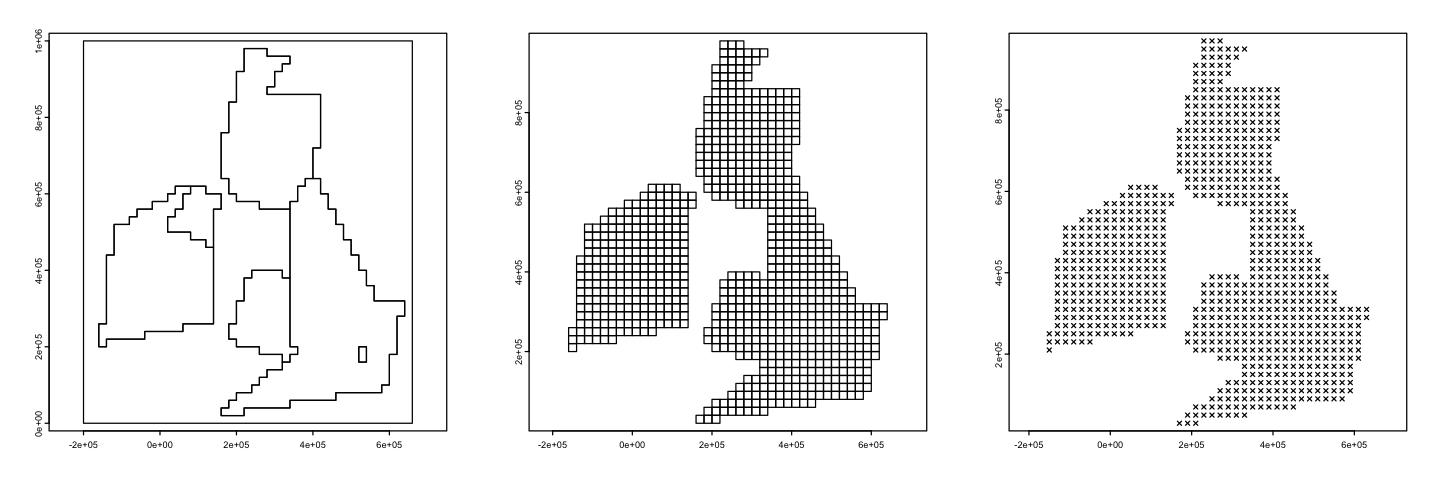

In [68]:
# Plot the outputs - using key.pos=NULL to suppress the key
par(mfrow=c(1,3), mar=c(1,1,1,1))
plot(poly_from_rast, key.pos = NULL)
plot(cells_from_rast, key.pos = NULL)
plot(points_from_rast, key.pos = NULL, pch=4)

## Using data in files

There are a huge range of different formats for spatial data. Fortunately, the `sf` and
`terra` packages make life easy: the `st_read` function in `sf` reads most vector data
and the `rast` function in `terra` reads most raster formats. There are odd file formats
that are harder to read but most are covered by these two packages. The two packages
also provide functions to save data to a file.

### Saving vector data

In [69]:
# This chunk removes existing demo outputs so they can be recreated in the 
# following chunks
files <- dir('data/uk', 'uk_eire*|uk_raster_*', full.names=TRUE)
print(files)
file.remove(files)

 [1] "data/uk/uk_eire_BNG.dbf"              
 [2] "data/uk/uk_eire_BNG.prj"              
 [3] "data/uk/uk_eire_BNG.shp"              
 [4] "data/uk/uk_eire_BNG.shx"              
 [5] "data/uk/uk_eire_WGS84.dbf"            
 [6] "data/uk/uk_eire_WGS84.geojson"        
 [7] "data/uk/uk_eire_WGS84.gpkg"           
 [8] "data/uk/uk_eire_WGS84.json"           
 [9] "data/uk/uk_eire_WGS84.prj"            
[10] "data/uk/uk_eire_WGS84.shp"            
[11] "data/uk/uk_eire_WGS84.shx"            
[12] "data/uk/uk_raster_BNG_interp.tif"     
[13] "data/uk/uk_raster_BNG_ngb.asc"        
[14] "data/uk/uk_raster_BNG_ngb.asc.aux.xml"
[15] "data/uk/uk_raster_BNG_ngb.prj"        


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

The most common vector data file format is the shapefile. This was developed by ESRI for
use in ArcGIS but has become a common standard. We can save our `uk_eire_sf` data to a
shapfile using the `st_write` function from the `sf` package.

In [70]:
st_write(uk_eire_sf, 'data/uk/uk_eire_WGS84.shp')
st_write(uk_eire_BNG, 'data/uk/uk_eire_BNG.shp')

Writing layer `uk_eire_WGS84' to data source 
  `data/uk/uk_eire_WGS84.shp' using driver `ESRI Shapefile'
Writing 6 features with 6 fields and geometry type Polygon.


Writing layer `uk_eire_BNG' to data source 
  `data/uk/uk_eire_BNG.shp' using driver `ESRI Shapefile'
Writing 6 features with 6 fields and geometry type Polygon.


If you look in the `data` directory, you see an irritating feature of the shapefile
format: **a shapefile is not a single file**. A shapefile consists of a set of files:
they all have the same name but different file suffixes and you need (at least) the
files ending with `.prj`, `.shp`, `.shx` and `.dbf`, which is what `st_write` has
created.

Other file formats are increasingly commonly used in place of the shapefile. ArcGIS has
moved towards the personal geodatabase but more portable options are:

- GeoJSON stores the coordinates and attributes in a single text file: it is
  _technically_ human readable but you have to be familiar with JSON data structures.
- GeoPackage stores vector data in a single SQLite3 database file. There are multiple
  tables inside this file holding various information about the data, but it is very
  portable and in a single file.

In [71]:
st_write(uk_eire_sf, 'data/uk/uk_eire_WGS84.geojson')
st_write(uk_eire_sf, 'data/uk/uk_eire_WGS84.gpkg')

Writing layer `uk_eire_WGS84' to data source 
  `data/uk/uk_eire_WGS84.geojson' using driver `GeoJSON'
Writing 6 features with 6 fields and geometry type Polygon.


Writing layer `uk_eire_WGS84' to data source 
  `data/uk/uk_eire_WGS84.gpkg' using driver `GPKG'
Writing 6 features with 6 fields and geometry type Polygon.


The `sf` package will try and choose the output format based on the file suffix (so
`.shp` gives ESRI Shapefile). If you don't want to use the standard file suffix, you can
also specify a **driver** directly: a driver is simply a bit of internal software that
reads or writes a particular format and you can see the list of available formats using
`st_drivers()`.

In [72]:
st_write(uk_eire_sf, 'data/uk/uk_eire_WGS84.json', driver='GeoJSON')

Writing layer `uk_eire_WGS84' to data source 
  `data/uk/uk_eire_WGS84.json' using driver `GeoJSON'
Writing 6 features with 6 fields and geometry type Polygon.


### Saving raster data

The GeoTIFF file format is one of the most common GIS raster data formats. It is
basically the same as a TIFF image file but contains embedded data describing the
origin, resolution and coordinate reference system of the data. Sometimes, you may also
see a `.tfw` file: this is a 'world' file that contains the same information and you
should probably keep it with the TIFF file.

We can use the `writeRaster` function from the `terra` package to save our raster data.
Again, the `terra` package will try and use the file name to choose a format but you can
also use `filetype` to set the driver used to write the data: see
[here](https://gdal.org/drivers/raster/index.html) for the (many!) options.

In [73]:
# Save a GeoTiff
writeRaster(uk_raster_BNG_interp, 'data/uk/uk_raster_BNG_interp.tif')
# Save an ASCII format file: human readable text. 
# Note that this format also creates an aux.xml and .prj file!
writeRaster(uk_raster_BNG_near, 'data/uk/uk_raster_BNG_ngb.asc', filetype='AAIGrid')

### Loading Vector data

As an example here, we will use the 1:110m scale Natural Earth data on countries. The
Natural Earth [website](https://www.naturalearthdata.com/) is a great open-source
repository for lots of basic GIS data. It also has a R package that provides access to
the data ([`rnaturalearth`](https://cran.r-project.org/web/packages/rnaturalearth/)),
but in practice downloading and saving the specific files you want isn't that hard!

We wil also use some downloaded WHO data. You will be unsurprised to hear that there is
an R package to access this data ([`WHO`](https://cran.r-project.org/web/packages/WHO))
but we'll use a already downloaded copy.

In [74]:
# Load a vector shapefile
ne_110 <- st_read('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# Also load some WHO data on 2016 life expectancy
# see: http://apps.who.int/gho/athena/api/GHO/WHOSIS_000001?filter=YEAR:2016;SEX:BTSX&format=csv
life_exp <- read.csv(file = "data/WHOSIS_000001.csv")

Reading layer `ne_110m_admin_0_countries' from data source 
  `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 177 features and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -90 xmax: 180 ymax: 83.64513
Geodetic CRS:  WGS 84


```{admonition} Create some global maps

Using the data loaded above, recreate the two plots shown below of global GDP and 2016
global life expectancy, averaged for both sexes. This only needs the plotting and
merging skills from above.

The GDP data is already in the `ne_110` data, but you will need to add the life
expectancy data to the GIS data. Getting country names to match between datasets is
unexpectedly a common problem: try using the `ISO_A3_EH` field in `ne_110`. The other
gotcha with merge is that, by default, the merge **drops rows** when there is no match.
Here, it makes sense to use `all.x=TRUE` to retain all the countries: they will get NA
values for the missing life expectancy.

The life expectancy plot has been altered to show less blocky colours in a nicer palette
(`hcl.colors` uses the `viridis` palette by default). You will need to set the `breaks`
and `pal` arguments to get this effect.
```

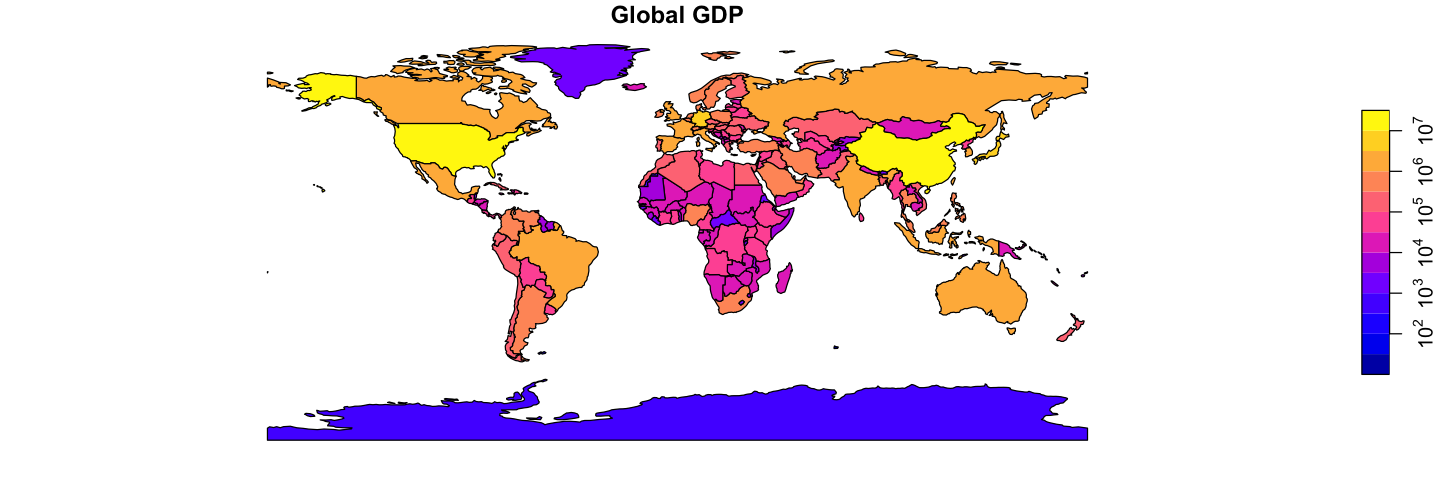

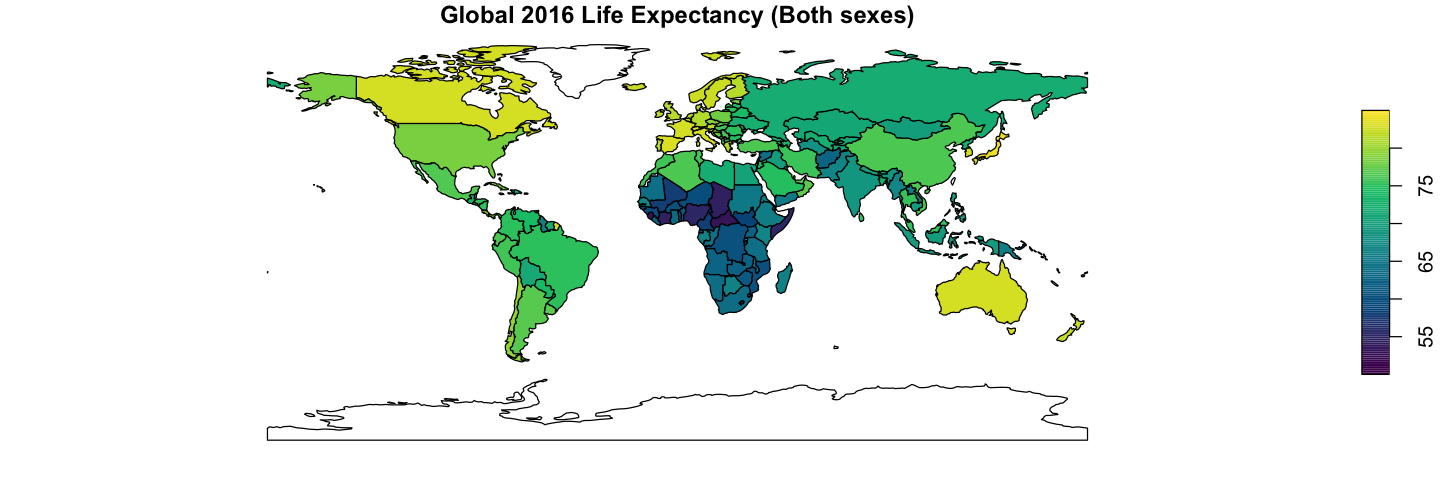

In [75]:
# Generate two stacked plots with narrow margins
par(mfrow=c(2,1), mar=c(1,1,1,1))

# The first plot is easy
plot(ne_110['GDP_MD'],  asp=1, main='Global GDP', logz=TRUE, key.pos=4)

# Then for the second we need to merge the data
ne_110 <- merge(ne_110, life_exp, by.x='ISO_A3_EH', by.y='COUNTRY', all.x=TRUE)
# Create a sequence of break values to use for display
bks <- seq(50, 85, by=0.25)
# Plot the data
plot(ne_110['Numeric'], asp=1, main='Global 2016 Life Expectancy (Both sexes)',
      breaks=bks, pal=hcl.colors, key.pos=4)

### Loading XY data

We've looked at this case earlier, but one common source of vector data is a table with
coordinates in it (either longitude and latitude for geographic coordinates or X and Y
coordinates for a projected coordinate system). We will load some data like this and
convert it into a proper `sf` object. You do have to know the coordinate system!

In [76]:
# Read in Southern Ocean example data
so_data <- read.csv('data/Southern_Ocean.csv', header=TRUE)

# Convert the data frame to an sf object
so_data <- st_as_sf(so_data, coords=c('long', 'lat'), crs=4326)
print(so_data)

Simple feature collection with 18 features and 3 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -53.03006 ymin: -63.25913 xmax: -25.35395 ymax: -50.28753
Geodetic CRS:  WGS 84
First 10 features:
   station krill_abun chlorophyll                    geometry
1        6   0.000000   1.0459308  POINT (-53.03006 -59.9096)
2        8   0.000000   0.7963782 POINT (-51.25974 -58.51637)
3       10  15.451699   0.8696133 POINT (-49.41599 -59.91357)
4       12  58.635360   0.3670812 POINT (-48.13545 -60.97059)
5       16   0.000000   0.9829019 POINT (-42.93436 -57.97091)
6       19   1.606727   1.6252205 POINT (-41.32185 -55.20345)
7       22  21.572858  16.8969183 POINT (-40.13592 -52.90708)
8       25   5.643033   0.9953874 POINT (-39.02036 -50.28753)
9       27   0.000000   6.3904550 POINT (-37.61516 -50.95719)
10      29   1.658074   0.4529254   POINT (-36.623 -52.68932)


### Loading Raster data

We will look at some global topographic data taken from the
[ETOPO1](https://www.ngdc.noaa.gov/mgg/global/) dataset. The original data is at 1 arc
minute (1/60°) and this file has been resampled to 15 arc minutes (0.25°) to make it a
bit more manageable (466.7Mb to 2.7 Mb).

In [77]:
options(repr.plot.width=10, repr.plot.height= 5) # Change plot sizes (in cm)

class       : SpatRaster 
dimensions  : 720, 1440, 1  (nrow, ncol, nlyr)
resolution  : 0.25, 0.25  (x, y)
extent      : -180, 180, -90, 90  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : etopo_25.tif 
name        :  etopo_25 
min value   : -9295.364 
max value   :  5930.763 


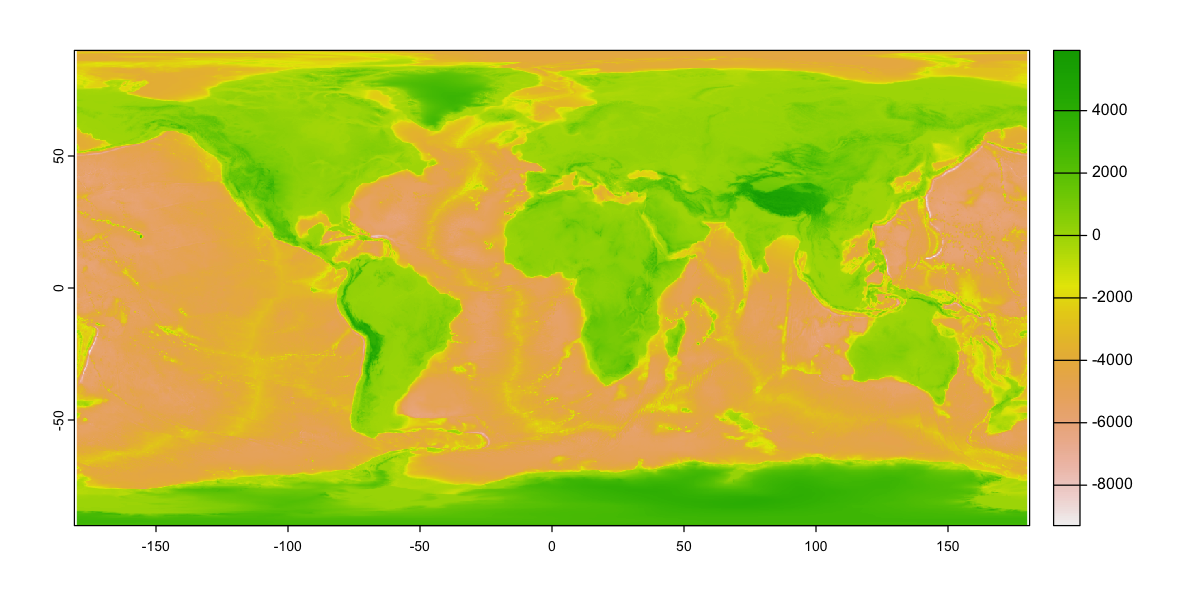

In [78]:
etopo_25 <- rast('data/etopo_25.tif')
# Look at the data content
print(etopo_25)
# Plot it 
plot(etopo_25, plg=list(ext=c(190, 200, -90, 90)))

```{admonition} Controlling raster plots

That isn't a particularly useful colour scheme. Can you work out how to create the plot
below? 

Some hints: 

* You'll need to set breaks again and then provide two colour palettes that match the
  values either side of 0. 
* The function `colorRampPalette` is really helpful here, or you could use the built-in
  palettes.
* You need to set the plot `type='continuous'` to get a continuous legend.
* The mysterious `plg` argument sets the extent of the legend box. It uses the same 
  coordinate system as the map: you can move the legend *inside* the plot or reserve
  a space outside the plot.
```

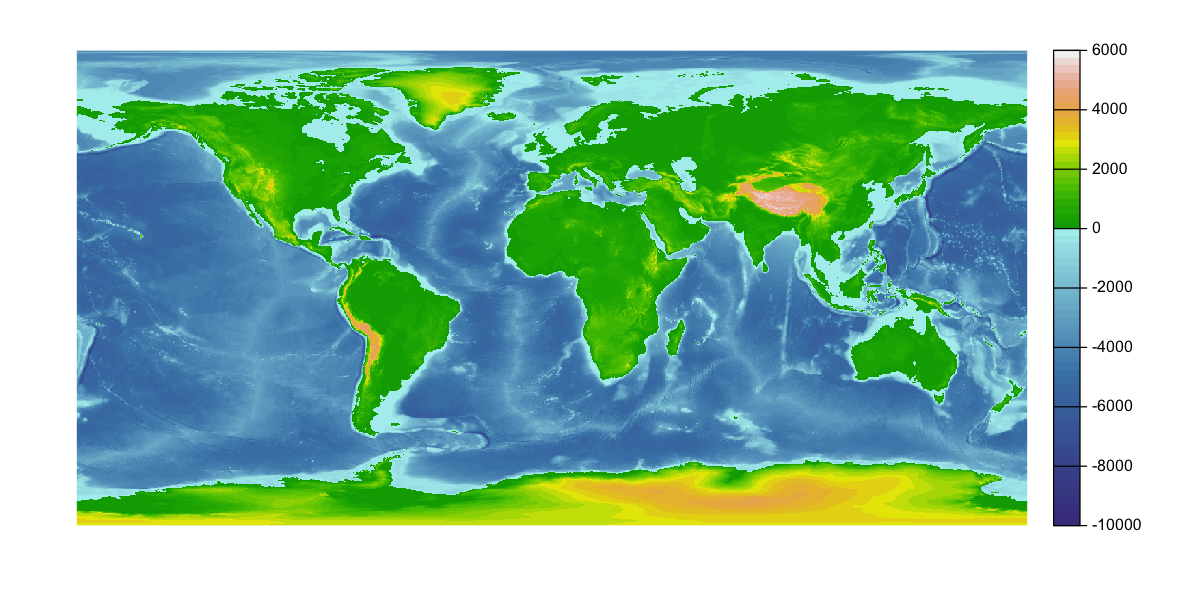

In [79]:
bks <- seq(-10000, 6000, by=250)
land_cols  <- terrain.colors(24)
sea_pal <- colorRampPalette(c('darkslateblue', 'steelblue', 'paleturquoise'))
sea_cols <- sea_pal(40)
plot(etopo_25, axes=FALSE, breaks=bks, 
     col=c(sea_cols, land_cols), type='continuous',  
     plg=list(ext=c(190, 200, -90, 90))
) 

### Raster Stacks

Raster data very often has multiple **bands**: a single file can contain multiple layers
of information for the cells in the raster grid. An obvious example is colour imagery,
where three layers hold red, green and blue values, but satellite data can contain many
layers holding different bands.

We will use the `geodata` package to get some data with monthly data bands. This package
provides a range of download functions for some key data repositories (see
`help(package='geodata')`. It will download the data automatically if needed and store
it locally. Note that you only need to download the data once. As long as you provide a
path to where the files were stored, it will note that you have a local copy and load
those, although you could also just use `rast` at this point!

We'll look at some global worldclim data
([http://worldclim.org/version2](http://worldclim.org/version2)) for maximum
temperature, which comes as a stack of monthly values. This data has already been
downloaded to the `data` directory using the `global_worldclim` function: using the
correct path will load it directly from the local copies in the `data` folder.

In [80]:
# Download bioclim data: global maximum temperature at 10 arc minute resolution
tmax <- worldclim_global(var='tmax', res=10, path='data')
# The data has 12 layers, one for each month
print(tmax)

class       : SpatRaster 
dimensions  : 1080, 2160, 12  (nrow, ncol, nlyr)
resolution  : 0.1666667, 0.1666667  (x, y)
extent      : -180, 180, -90, 90  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
sources     : wc2.1_10m_tmax_01.tif  
              wc2.1_10m_tmax_02.tif  
              wc2.1_10m_tmax_03.tif  
              ... and 9 more source(s)
names       : wc2.1~ax_01, wc2.1~ax_02, wc2.1~ax_03, wc2.1~ax_04, wc2.1~ax_05, wc2.1~ax_06, ... 
min values  :     -42.419,   -39.58325,   -53.40000,   -59.54875,    -59.8395,    -60.3600, ... 
max values  :      42.157,    40.26450,    41.48825,    43.17525,     44.8155,     46.6155, ... 


<!-- One odd thing about that data is the range of values: `-478` to `489`. It is *really
common* for GIS data to be stored in a form that needs scaling by the end user and this
is what is going on here. The metadata for a raster data set should include any scale
and offset values needed but you need to check that any variables you use are correctly
scaled.

The reason to do this is to minimise disk use: `-478` to `489` can be stored really
easily as integer data with 2 bytes per number (`Int16`). If it was stored as float data
(with a decimal point), it would be 4 bytes per number (`Float32`) or worse (`Float64`).
So, the data file is half the size and - since the data is only accurate to 1 decimal
place - we have no loss of precision. -->

We can access different layers using `[[`. We can also use aggregate functions (like
`sum`, `mean`, `max` and `min`) to extract information across layers

In [81]:
options(repr.plot.width=12, repr.plot.height= 6) # Change plot sizes (in cm)

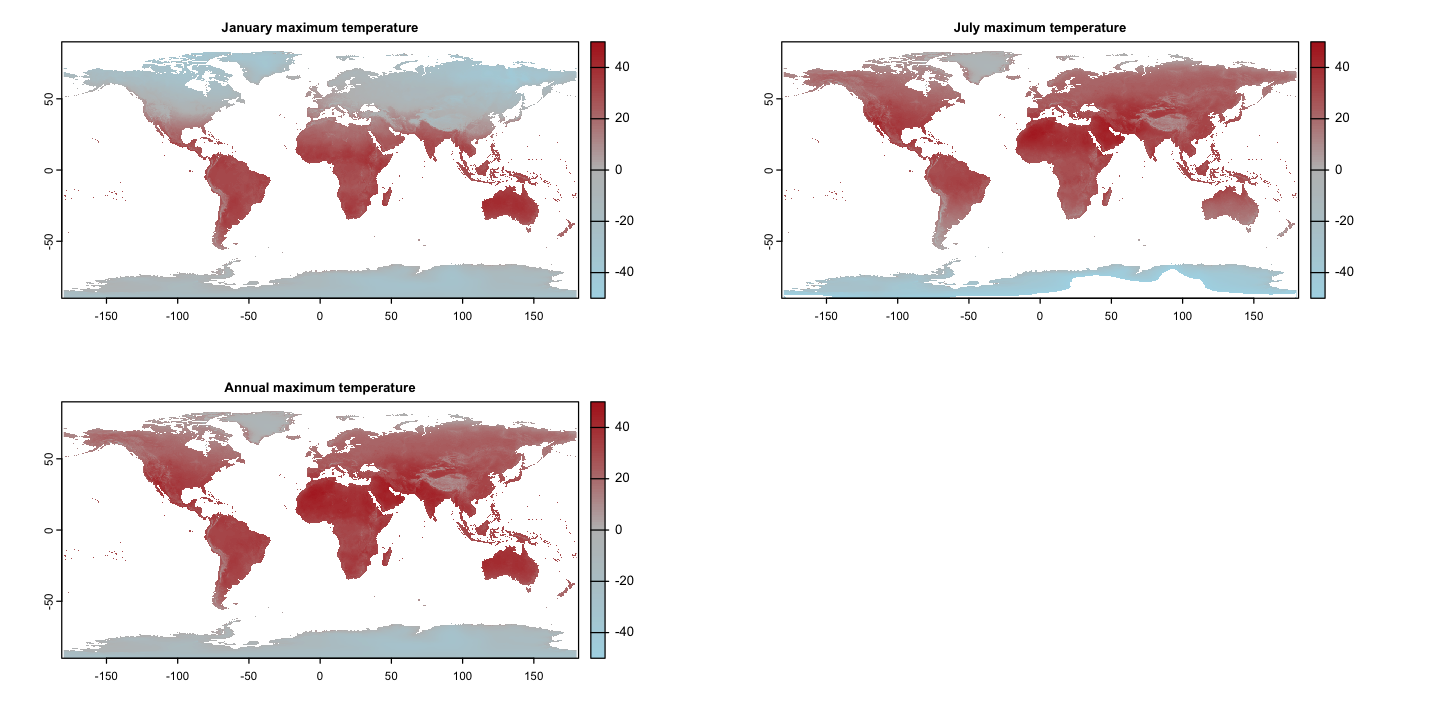

In [82]:
# Extract  January and July data and the annual maximum by location.
tmax_jan <- tmax[[1]]
tmax_jul <- tmax[[7]]
tmax_max <- max(tmax)

# Plot those maps
par(mfrow=c(2,2), mar=c(2,2,1,1))
bks <- seq(-50, 50, length=101)
pal <- colorRampPalette(c('lightblue','grey', 'firebrick'))
cols <- pal(100)
plg <- list(ext=c(190, 200, -90, 90))

plot(tmax_jan, col=cols, breaks=bks, 
     main='January maximum temperature', type='continuous', plg=plg)
plot(tmax_jul, col=cols, breaks=bks, 
     main='July maximum temperature', type='continuous', plg=plg)
plot(tmax_max, col=cols, breaks=bks, 
     main='Annual maximum temperature', type='continuous', plg=plg)

## Overlaying raster and vector data

In this next exercise, we are going to use some data to build up a more complex map of
chlorophyll concentrations in the Southern Ocean. There are a few new techniques along
the way.

### Cropping data

Sometimes you are only interested in a subset of the area covered by a GIS dataset.
Cropping the data to the area of interest can make plotting easier and can also make GIS
operations a lot faster, particularly if the data is complex.

In [83]:
so_extent <- ext(-60, -20, -65, -45)

# The crop function for raster data...
so_topo <- crop(etopo_25, so_extent)

# ... and the st_crop function to reduce some higher resolution coastline data
ne_10 <- st_read('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
st_agr(ne_10) <- 'constant'
so_ne_10 <- st_crop(ne_10, so_extent)

Reading layer `ne_10m_admin_0_countries' from data source 
  `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 258 features and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -90 xmax: 180 ymax: 83.6341
Geodetic CRS:  WGS 84


although coordinates are longitude/latitude, st_intersection assumes that they are planar



```{admonition} Plotting Southern Ocean chlorophyll

Using the data loaded above, recreate this map. For continuous raster data, contours can
help make the data a bit clearer or replace a legend and are easy to add using the
`contour` function with a raster object.
```

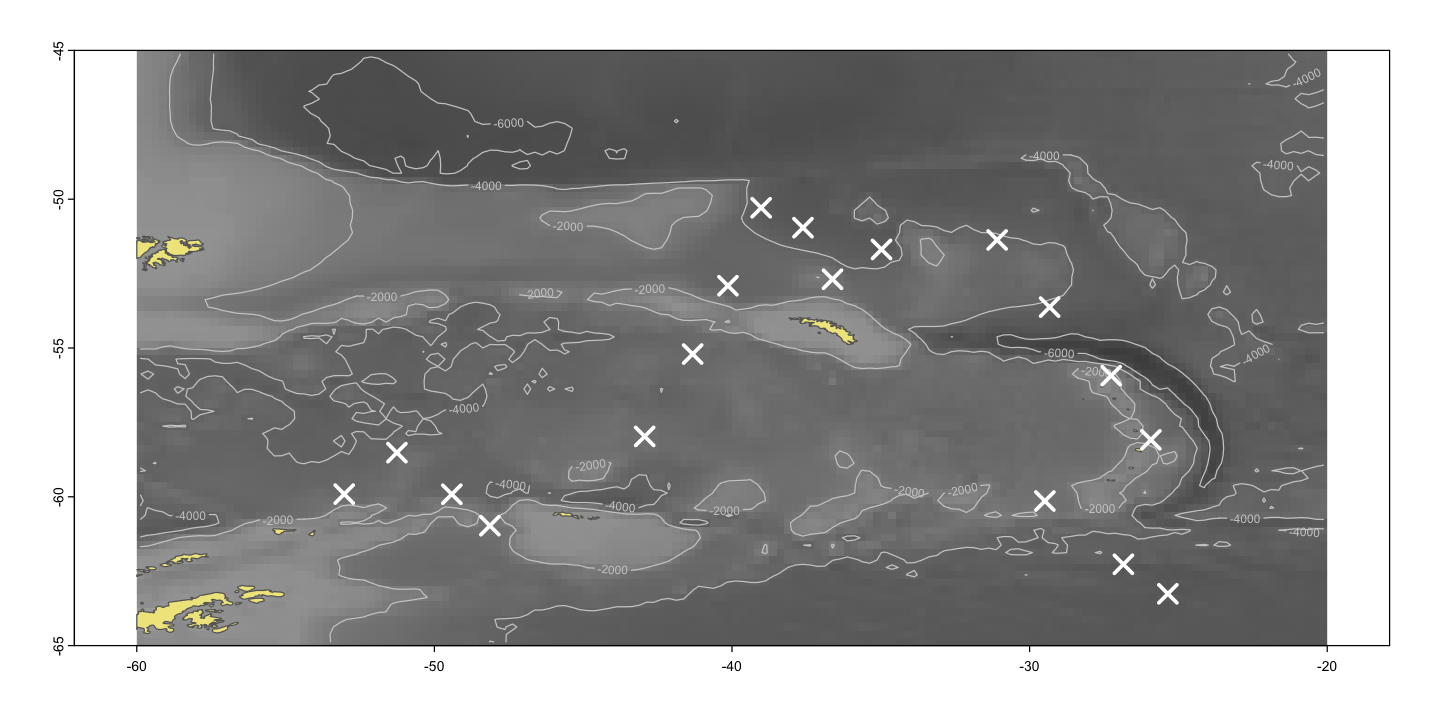

In [84]:
sea_pal <- colorRampPalette(c('grey30', 'grey50', 'grey70'))

# Plot the underlying sea bathymetry
plot(so_topo, col=sea_pal(100), asp=1, legend=FALSE)
contour(so_topo, levels=c(-2000, -4000, -6000), add=TRUE, col='grey80')

# Add the land
plot(st_geometry(so_ne_10), add=TRUE, col='khaki', border='grey40')

# Show the sampling sites
plot(st_geometry(so_data), add=TRUE, pch=4, cex=2, col='white', lwd=3)

## Spatial joins and raster data extraction

### Spatial joining

We have merged data into an `sf` object by matching values in columns, but we can also
merge data **spatially**. This process is often called a **spatial join**.

As an example, we are going to look at mapping 'mosquito outbreaks' in Africa: we are
actually going to use some random data, mostly to demonstrate the useful `st_sample`
function. We would like to find out whether any countries are more severely impacted in
terms of both the area of the country and their population size.

In [85]:
options(repr.plot.width=7, repr.plot.height= 7) # Change plot sizes (in cm)

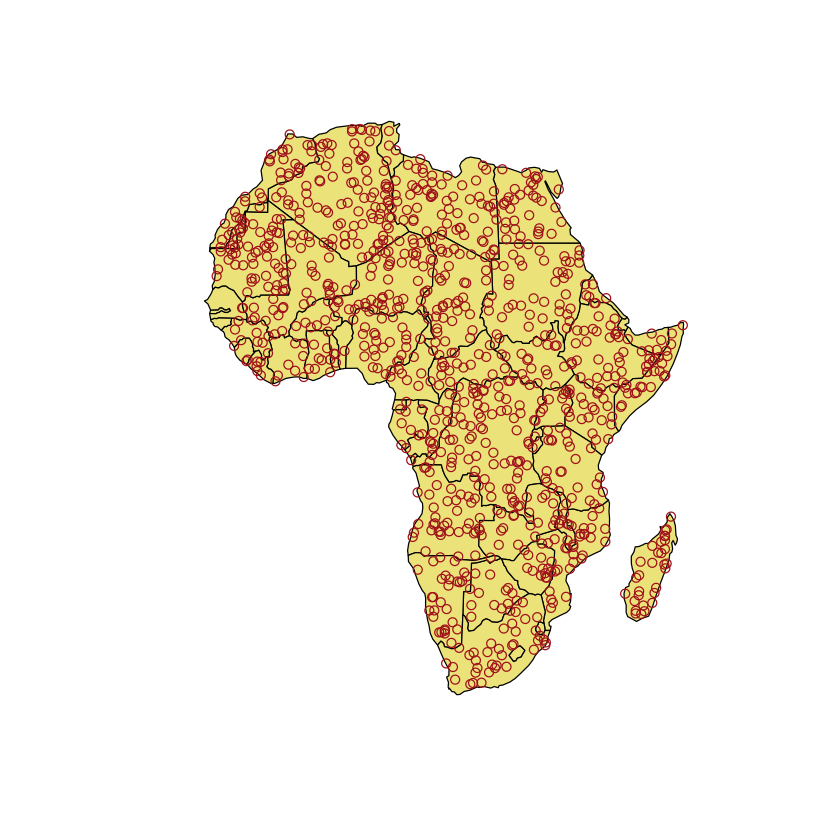

In [86]:
set.seed(1)
# extract Africa from the ne_110 data and keep the columns we want to use
africa <- subset(ne_110, CONTINENT=='Africa', select=c('ADMIN', 'POP_EST'))

# transform to the Robinson projection
africa <- st_transform(africa, crs='ESRI:54030')
# create a random sample of points
mosquito_points <- st_sample(africa, 1000)

# Create the plot
plot(st_geometry(africa), col='khaki')
plot(mosquito_points, col='firebrick', add=TRUE)

In order to join these data together we need to turn the `mosquito_points` object from a
geometry column (`sfc`) into a full `sf` data frame, so it can have attributes and then
we can simply add the country name ('ADMIN') onto the points.

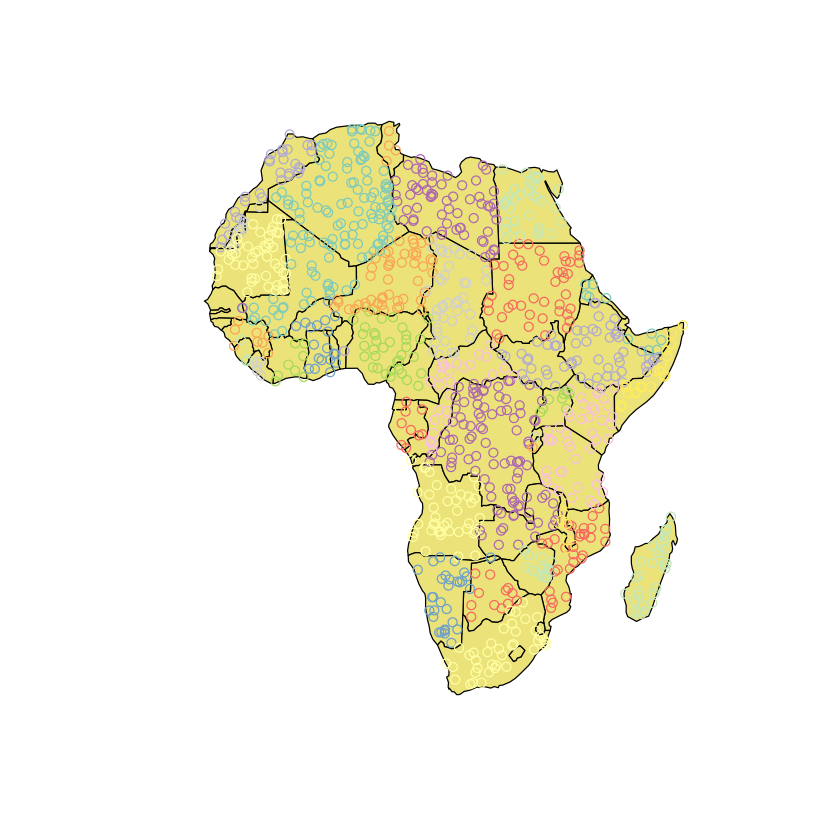

In [87]:
mosquito_points <- st_sf(mosquito_points)
mosquito_points <- st_join(mosquito_points, africa['ADMIN'])

plot(st_geometry(africa), col='khaki')

# Add points coloured by country
plot(mosquito_points['ADMIN'], add=TRUE)

We can now aggregate the points within countries. This can give us a count of the number
of points in each country and also converts multiple rows of `POINT` into a single
`MULTIPOINT` feature per country.

In [88]:
mosquito_points_agg <- aggregate(
     mosquito_points, 
     by=list(country=mosquito_points$ADMIN), FUN=length
)
names(mosquito_points_agg)[2] <-'n_outbreaks'
print(mosquito_points_agg)

Simple feature collection with 47 features and 2 fields
Attribute-geometry relationship: 0 constant, 0 aggregate, 1 identity, 1 NA's
Geometry type: GEOMETRY
Dimension:     XY
Bounding box:  xmin: -1484747 ymin: -3582975 xmax: 4791173 ymax: 3890233
Projected CRS: World_Robinson
First 10 features:
                            country n_outbreaks                       geometry
1                           Algeria          91 MULTIPOINT ((-682422.1 2972...
2                            Angola          41 MULTIPOINT ((1133960 -56731...
3                             Benin           1      POINT (236471.4 903118.7)
4                          Botswana          12 MULTIPOINT ((1943318 -26749...
5                      Burkina Faso           7 MULTIPOINT ((-415457.6 1238...
6                           Burundi           1      POINT (2768345 -393948.5)
7                          Cameroon          10 MULTIPOINT ((855976.4 55643...
8          Central African Republic          17 MULTIPOINT ((1394914 49

In [89]:
# Merge the number of outbreaks back onto the sf data
africa <- st_join(africa, mosquito_points_agg)
africa$area <- as.numeric(st_area(africa))
print(africa)

Simple feature collection with 51 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -1649109 ymin: -3723994 xmax: 4801039 ymax: 3994212
Projected CRS: World_Robinson
First 10 features:
                              ADMIN  POP_EST                          country
2                        Somaliland  5096159                       Somaliland
5                            Angola 31825295                           Angola
15                          Burundi 11530580                          Burundi
17                            Benin 11801151                            Benin
18                     Burkina Faso 20321378                     Burkina Faso
29                         Botswana  2303697                         Botswana
30         Central African Republic  4745185         Central African Republic
35                      Ivory Coast 25716544                      Ivory Coast
36                         Cameroon 25876380                         Camer

In [90]:
options(repr.plot.width=12, repr.plot.height= 6) # Change plot sizes (in cm)

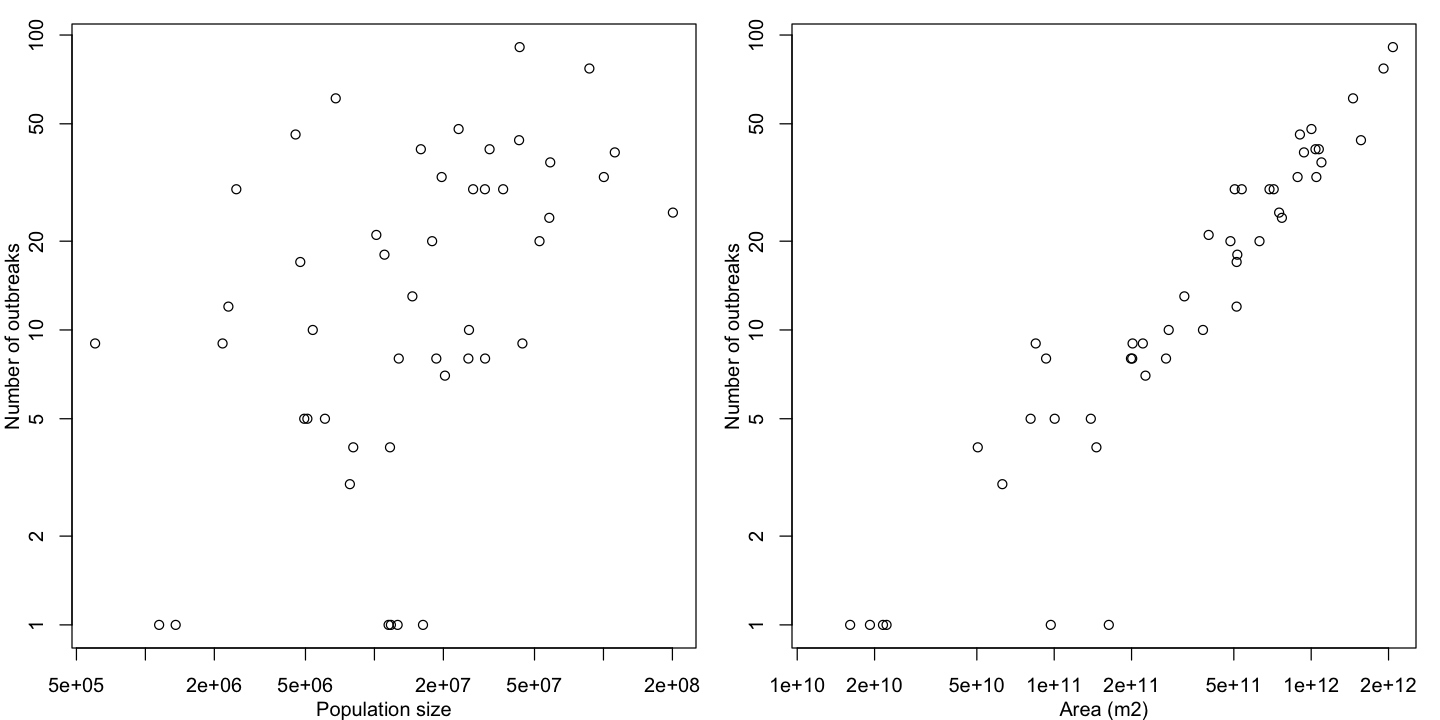

In [91]:
# Plot the results
par(mfrow=c(1,2), mar=c(3,3,1,1), mgp=c(2,1, 0))
plot(n_outbreaks ~ POP_EST, data=africa, log='xy', 
     ylab='Number of outbreaks', xlab='Population size')
plot(n_outbreaks ~ area, data=africa, log='xy',
     ylab='Number of outbreaks', xlab='Area (m2)')

```{admonition} Alien invasion

Martians have invaded! 

* Jeff and Will have managed to infiltrate the alien mothership
  and have sent back the key data on landing sites and the number of aliens in each ship.

* The landing sites are in the file `data/aliens.csv` as WGS84 coordinates. It seems
  strange that aliens also use WGS84, but it makes life easier!

* We need to work out which countries are going
  to be overwhelmed by aliens. We think that countries with more than about 1000 people
  per alien are going to be ok, but we need a map of alien threat like the one below.

Can you produce the map countries at risk shown below?
```

although coordinates are longitude/latitude, st_intersects assumes that they are planar



although coordinates are longitude/latitude, st_intersects assumes that they are planar



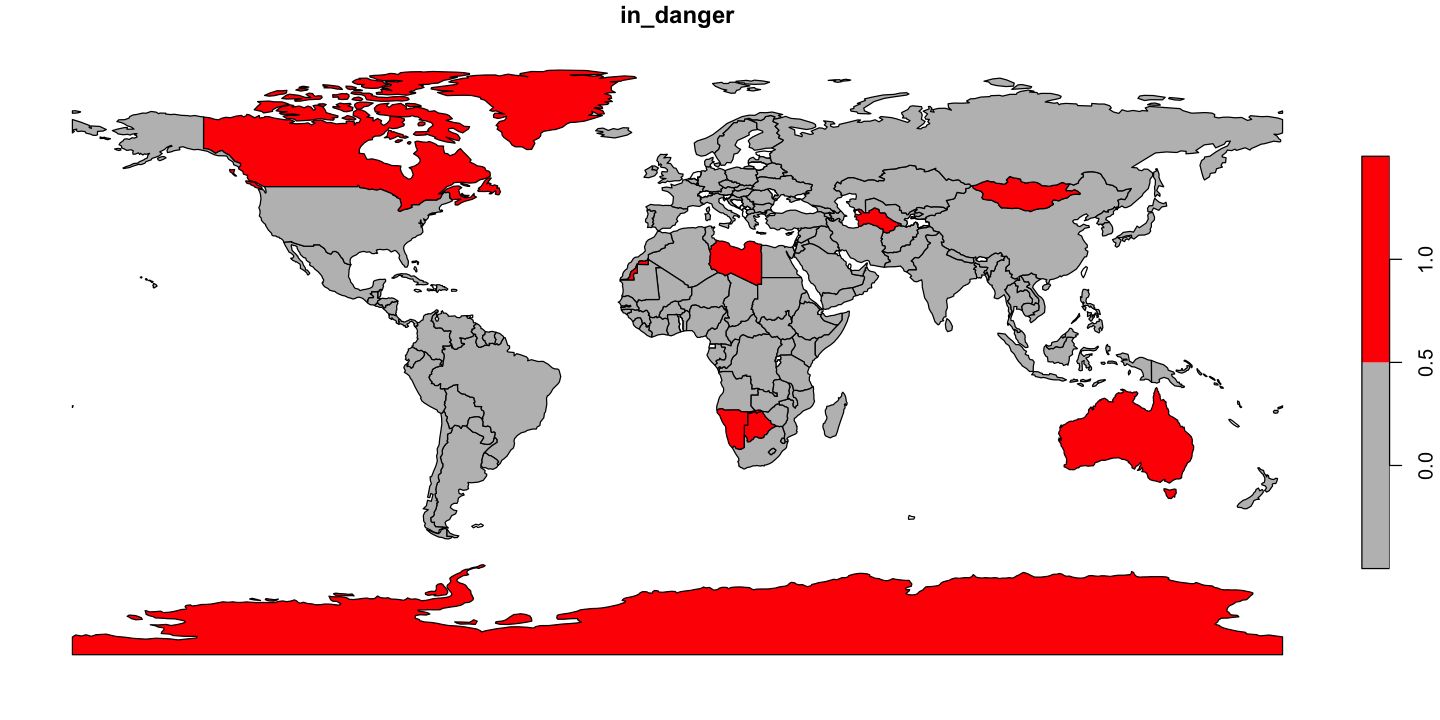

In [92]:
# Load the data and convert to a sf object
alien_xy <- read.csv('data/aliens.csv')
alien_xy <- st_as_sf(alien_xy, coords=c('long','lat'), crs=4326)

# Add country information and find the total number of aliens per country
alien_xy <- st_join(alien_xy, ne_110['ADMIN'])
aliens_by_country <- aggregate(n_aliens ~ ADMIN, data=alien_xy, FUN=sum)

# Add the alien counts into the country data 
ne_110 <- merge(ne_110, aliens_by_country, all.x=TRUE)
ne_110$people_per_alien <- with(ne_110,  POP_EST / n_aliens )

# Find which countries are in danger
ne_110$in_danger <- ne_110$people_per_alien < 1000

# Plot the danger map
plot(ne_110['in_danger'], pal=c('grey', 'red'), key.pos=4)

### Extracting data from Rasters

The spatial join above allows us to connect vector data based on location but you might
also need to extract data from a raster dataset in certain locations. Examples include
to know the exact altitude or surface temperature of sampling sites or average values
within a polygon. We are going to use a chunk of the full resolution ETOPO1 elevation
data to explore this.

In [93]:
uk_eire_etopo <- rast('data/uk/etopo_uk.tif')

```{admonition} Masking elevation data
Before we can do this, ETOPO data include bathymetry as well as elevation. Use the
`rasterize` function on the high resolution `ne_10` dataset to get a land raster
matching `uk_eire_etopo` and then use the `mask` function to create the elevation map.
You should end up converting the raw data on the left to the map on the right
```

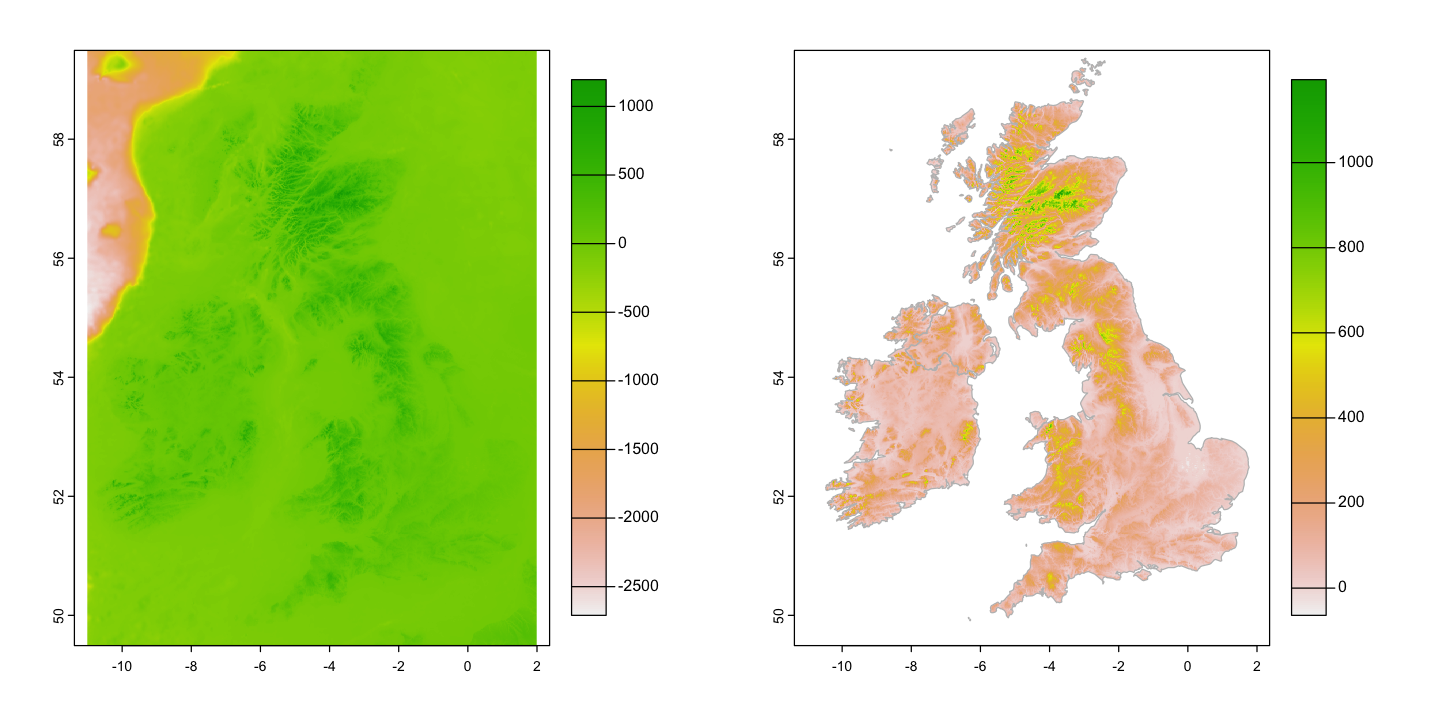

In [94]:
uk_eire_detail <- subset(ne_10, ADMIN %in% c('United Kingdom', "Ireland"))
uk_eire_detail_raster <- rasterize(uk_eire_detail, uk_eire_etopo)
uk_eire_elev <- mask(uk_eire_etopo, uk_eire_detail_raster)

par(mfrow=c(1,2), mar=c(3,3,1,1), mgp=c(2,1,0))
plot(uk_eire_etopo, plg=list(ext=c(3,4, 50, 59)))
plot(uk_eire_elev, plg=list(ext=c(3,4, 50, 59)))
plot(st_geometry(uk_eire_detail), add=TRUE, border='grey')

### Raster cell statistics and locations

The `global` function provides a way to find global summary statistics of the data in a
raster. We can also find out the locations of cells with particular characteristics
using `where.max` of `where.min`. Both of those functions return cell ID numbers, but
the `xyFromCell` allows you to turn those ID numbers into coordinates.

In [95]:
uk_eire_elev >= 1195

class       : SpatRaster 
dimensions  : 600, 780, 1  (nrow, ncol, nlyr)
resolution  : 0.01666667, 0.01666667  (x, y)
extent      : -11.00833, 1.991667, 49.49167, 59.49167  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : memory 
name        : etopo_uk 
min value   :    FALSE 
max value   :     TRUE 

In [96]:
global(uk_eire_elev, max, na.rm=TRUE)
global(uk_eire_elev, quantile, na.rm=TRUE)

# Which is the highest cell
where.max(uk_eire_elev)

max 
etopo_uk 1195

X0. X25. X50. X75. X100.
etopo_uk -64 53   104  204  1195

layer cell   value
[1,] 1     113536 1195

In [97]:
# Which cells are above 1100m
high_points <- where.max(uk_eire_elev >= 1100, value=FALSE)
xyFromCell(uk_eire_elev, high_points[,2])

x         y       
[1,] -3.683333 57.10000
[2,] -3.666667 57.10000
[3,] -3.666667 57.08333
[4,] -3.500000 57.08333
[5,] -3.750000 57.06667
[6,] -3.666667 57.06667
[7,] -3.716667 57.05000

```{admonition} Highlight highest point and areas below sea level
Plot the locations of the maximum altitude and cells below sea level on the map. Some 
questions about the result:

* Is the maximum altitude the _real_ maximum altitude in the UK? If not, why not? 
* Why do so many points have elevations below sea level? There are two reasons!
```

In [98]:
options(repr.plot.width=7, repr.plot.height= 7) # Change plot sizes (in cm)

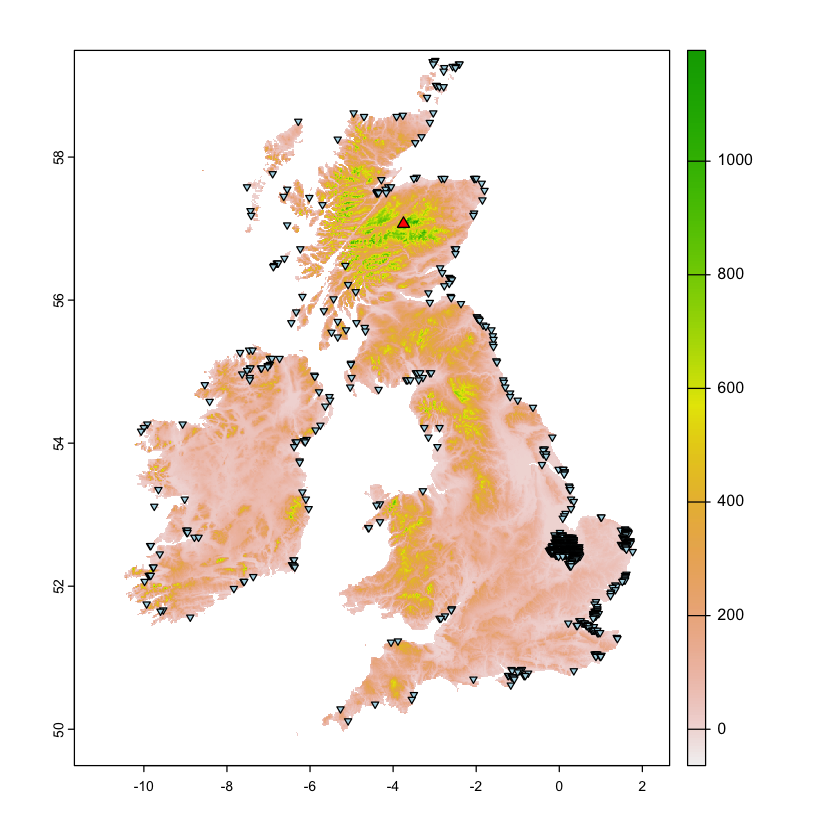

In [99]:
max_cell <- where.max(uk_eire_elev)
max_xy <- xyFromCell(uk_eire_elev, max_cell[2])
max_sfc<- st_sfc(st_point(max_xy), crs=4326)

bsl_cell <- where.max(uk_eire_elev < 0, values=FALSE)
bsl_xy <- xyFromCell(uk_eire_elev, bsl_cell[,2])
bsl_sfc <- st_sfc(st_multipoint(bsl_xy), crs=4326)

plot(uk_eire_elev)
plot(max_sfc, add=TRUE, pch=24, bg='red')
plot(bsl_sfc, add=TRUE, pch=25, bg='lightblue', cex=0.6)

### The extract function

The previous section shows the basic functions needed to get at raster data but the
`extract` function makes it easier. It works in different ways on different geometry
types:

- POINT: extract the values under the points.
- LINESTRING: extract the values under the linestring
- POLYGON: extract the values within the polygon

Extracting raster values under points is really easy.

In [100]:
uk_eire_capitals$elev <- extract(uk_eire_elev, uk_eire_capitals, ID=FALSE)
print(uk_eire_capitals)

Simple feature collection with 5 features and 2 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -6.25 ymin: 51.5 xmax: -0.1 ymax: 55.8
Geodetic CRS:  WGS 84
       name           geometry etopo_uk
1    London  POINT (-0.1 51.5)        8
2   Cardiff  POINT (-3.2 51.5)       21
3 Edinburgh  POINT (-3.2 55.8)      279
4   Belfast    POINT (-6 54.6)      269
5    Dublin POINT (-6.25 53.3)       43


Polygons are also easy but there is a little more detail about the output. The `extract`
function for polygons returns a data frame of **individual raster cell values** within
each polygon, along with an ID code showing the polygon ID:

In [101]:
etopo_by_country <- extract(uk_eire_elev, uk_eire_sf['name'])
head(etopo_by_country)

ID etopo_uk
1 1  NA      
2 1  94      
3 1  42      
4 1   1      
5 1   7      
6 1   0

You can always do summary statistics across those values:

In [102]:
aggregate(etopo_uk ~ ID, data=etopo_by_country, FUN='mean', na.rm=TRUE)

ID etopo_uk 
1 1  108.64256
2 2  110.57183
3 3   57.20426
4 4  125.03498
5 5  270.16737
6 6  218.65102

However, you can also use the `zonal` function to specify a summary statistic that
should be calculated within polygons. This mirrors the extremely useful **Zonal
Statistics** function from other GIS programs. You do have to provide a matching raster
of zones to use `zonal`:

In [103]:
zones <- rasterize(st_transform(uk_eire_sf, 4326), uk_eire_elev, field='name')
etopo_by_country <- zonal(uk_eire_elev, zones, fun='mean', na.rm=TRUE)

print(etopo_by_country)

              name  etopo_uk
1             Eire 108.64256
2          England 110.57183
3           London  57.20426
4 Northern Ireland 125.03498
5         Scotland 270.16737
6            Wales 218.65102


Extracting values under linestrings is more complicated. The basic option works in the
same way - the function returns the values underneath the line. If you want to tie the
values to locations on the line then you need to work a bit harder:

- By default, the function just gives the sample of values under the line, in no
  particular order. The `along=TRUE` argument preserves the order along the line.
- It is also useful to able to know *which* cell gives each value. The
  `cellnumbers=TRUE` argument allow us to retrieve this information.

We are going to get a elevation transect for the
[Pennine Way](https://www.nationaltrail.co.uk/pennine-way): a 429 km trail across some
of the wildest bits of England. The data for the trail comes as a GPX file, commonly
used in GPS receivers.

One feature of GPX files is that they contain multiple **layers**: essentially different
GIS datasets within a single source. The `st_layers` function allows us to see the names
of those layers so we can load the one we want.

In [104]:
st_layers('data/uk/National_Trails_Pennine_Way.gpx')

Driver: GPX 
Available layers:
    layer_name     geometry_type features fields crs_name
1    waypoints             Point        0     23   WGS 84
2       routes       Line String        5     12   WGS 84
3       tracks Multi Line String        0     12   WGS 84
4 route_points             Point    10971     25   WGS 84
5 track_points             Point        0     26   WGS 84

In [105]:
# load the data, showing off the ability to use SQL queries to load subsets of the data
pennine_way <- st_read('data/uk/National_Trails_Pennine_Way.gpx',
                      query="select * from routes where name='Pennine Way'")

Reading query `select * from routes where name='Pennine Way'' from data source `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_data/uk/National_Trails_Pennine_Way.gpx' 
  using driver `GPX'
Simple feature collection with 1 feature and 12 fields
Geometry type: LINESTRING
Dimension:     XY
Bounding box:  xmin: -2.562267 ymin: 53.36435 xmax: -1.816825 ymax: 55.54717
Geodetic CRS:  WGS 84


Before we do anything else, all of our data (`etopo_uk` and `pennine_way`) are in WGS84.
It really does not make sense to calculate distances and transects on a geographic
coordinate system so:

```{admonition} Reproject the Penine Way
Create `uk_eire_elev_BNG` and `pennine_way_BNG` by reprojecting the elevation raster 
and route vector into the British National Grid. Use a 2km resolution grid.
```

In [106]:
# reproject the vector data
pennine_way_BNG <- st_transform(pennine_way, crs=27700)
# create the target raster and project the elevation data into it.
bng_2km <- rast(xmin=-200000, xmax=700000, ymin=0, ymax=1000000, 
                res=2000, crs='EPSG:27700')
uk_eire_elev_BNG <- project(uk_eire_elev, bng_2km, method='cubic')

The route data is also very detailed, which is great if you are navigating in a blizzard
but does take a long time to process for this exercise. So, we'll also simplify the
route data before we use it. We'll use a 100m tolerance for simplifying the route: it
goes from 31569 points to 1512 points. You can see the difference on the two plots below
and this is worth remembering: **do you really need to use the highest resolution data
available**?

In [107]:
options(repr.plot.width=12, repr.plot.height= 8) # Change plot sizes (in cm)

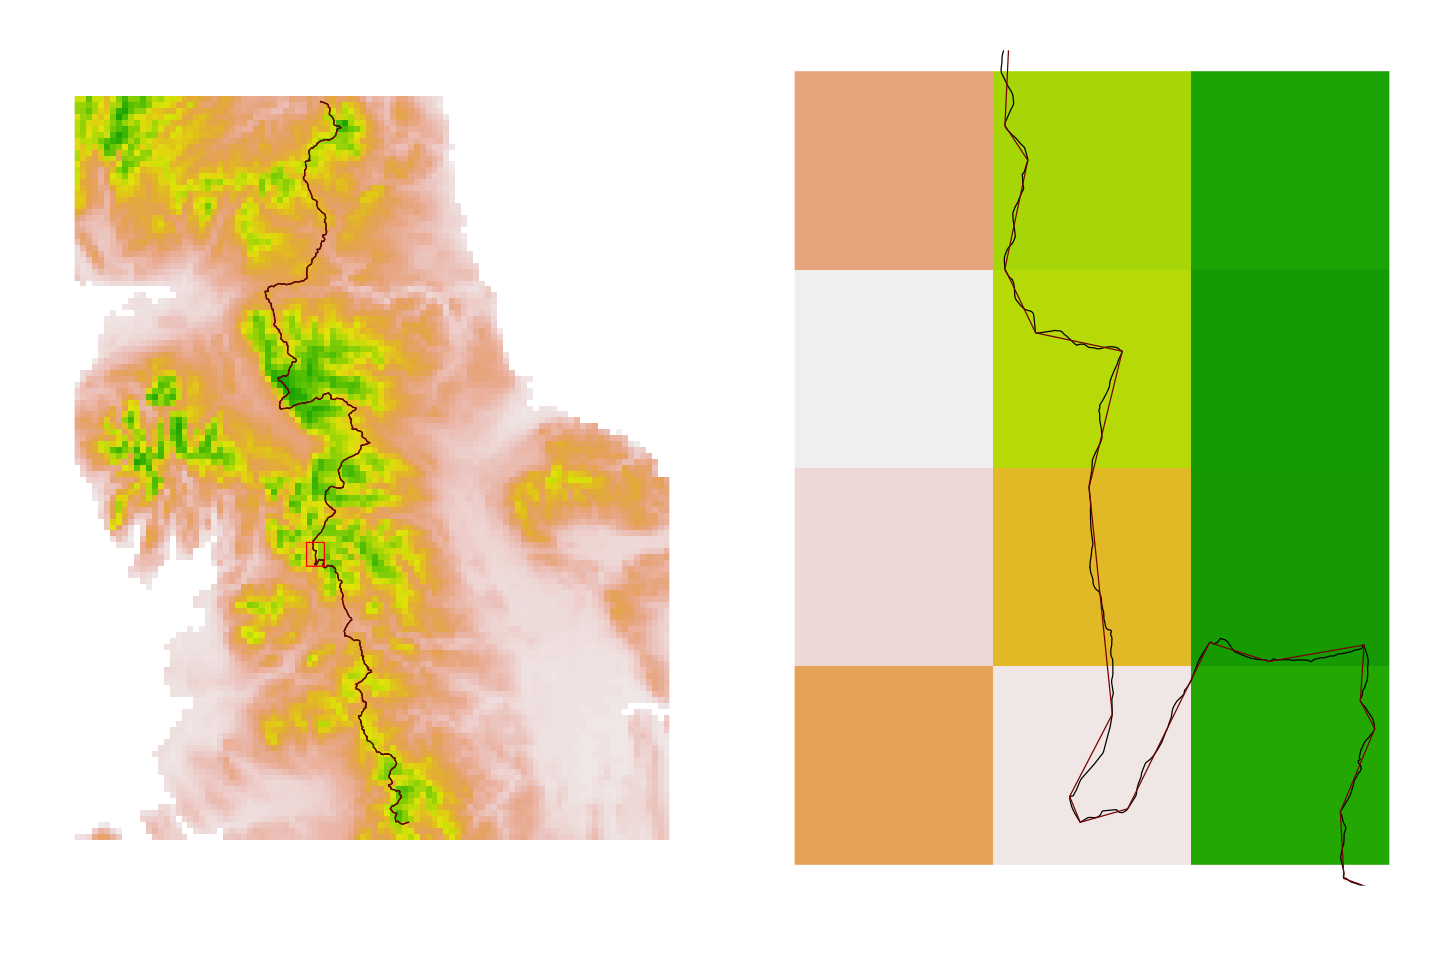

In [108]:
# Simplify the data
pennine_way_BNG_simple <- st_simplify(pennine_way_BNG,  dTolerance=100)

# Zoom in to the whole route and plot the data
par(mfrow=c(1,2), mar=c(1,1,1,1))

plot(uk_eire_elev_BNG, xlim=c(3e5, 5e5), ylim=c(3.8e5, 6.3e5),
     axes=FALSE, legend=FALSE)
plot(st_geometry(pennine_way_BNG), add=TRUE, col='black')
plot(st_geometry(pennine_way_BNG_simple), add=TRUE, col='darkred')

# Add a zoom box and use that to create a new plot
zoom <- ext(3.78e5, 3.84e5, 4.72e5, 4.80e5)
plot(zoom, add=TRUE, border='red')

# Zoomed in plot
plot(uk_eire_elev_BNG, ext=zoom, axes=FALSE, legend=FALSE)
plot(st_geometry(pennine_way_BNG), add=TRUE, col='black')
plot(st_geometry(pennine_way_BNG_simple), add=TRUE, col='darkred')

Now we can extract the elevations, cell IDs and the XY coordinates of cells falling
under that route. We can simply use Pythagoras' Theorem to find the distance between
cells along the transect and hence the cumulative distance.

In [109]:
# Extract the data
pennine_way_trans <- extract(uk_eire_elev_BNG, pennine_way_BNG_simple, xy=TRUE)
head(pennine_way_trans)

ID etopo_uk x      y     
1 1  134.8042 383000 629000
2 1  193.3675 383000 627000
3 1  269.3795 385000 627000
4 1  315.7049 385000 625000
5 1  423.4430 385000 623000
6 1  443.0962 387000 623000

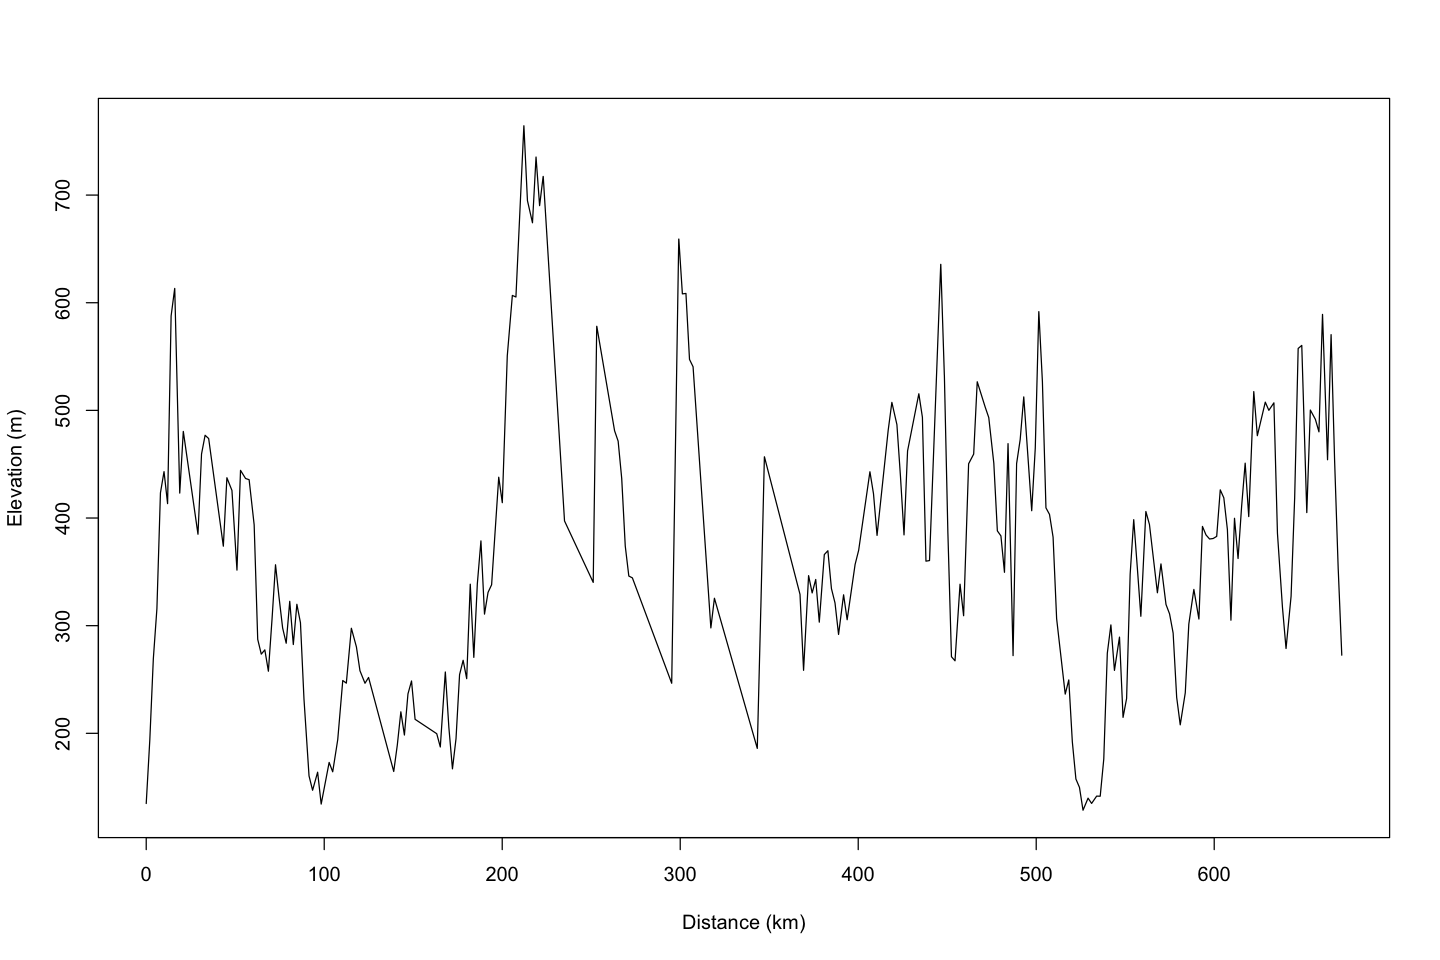

In [110]:
# Now we can use Pythagoras to find the distance along the transect
pennine_way_trans$dx <- c(0, diff(pennine_way_trans$x))
pennine_way_trans$dy <- c(0, diff(pennine_way_trans$y))
pennine_way_trans$distance_from_last <- with(pennine_way_trans, sqrt(dx^2 + dy^2))
pennine_way_trans$distance <- cumsum(pennine_way_trans$distance_from_last) / 1000

plot( etopo_uk ~ distance, data=pennine_way_trans, type='l', 
     ylab='Elevation (m)', xlab='Distance (km)')

## Mini projects

You should now have the skills to tackle the miniproject below. Give them a go - the
answers are still available but try and puzzle it out.

### Precipitation transect for  New Guinea

You have been given the following WGS84 coordinates of a transect through New Guinea

In [111]:
transect_long <- c(132.3, 135.2, 146.4, 149.3)
transect_lat <- c(-1, -3.9, -7.7, -9.8)

```{admonition} Create a total annual precipitation transect for New Guinea

* Use the 0.5 arc minute worldclim precipitation data from the `worldclim_tile` function
  in `geodata` - you will need to specify a location to get the tile including New
  Guinea.
* That data is monthly - you will need to sum across layers to get annual totals.
* Use UTM 54S ([https://epsg.io/32754](https://epsg.io/32754)) and use a 1 km resolution
  to reproject raster data. You will need to find an extent in UTM 54S to cover the
  study area and choose extent coordinates to create neat 1km cell boundaries
* Create a transect with the provided coordinates.
* You will need to reproject the transect into UTM 54S and then use the function
  `st_segmentize` to create regular 1000m sampling points along the transect.

Note that some of these steps are handling a lot of data and may take a few minutes to
complete. 
```

although coordinates are longitude/latitude, st_intersection assumes that they are planar



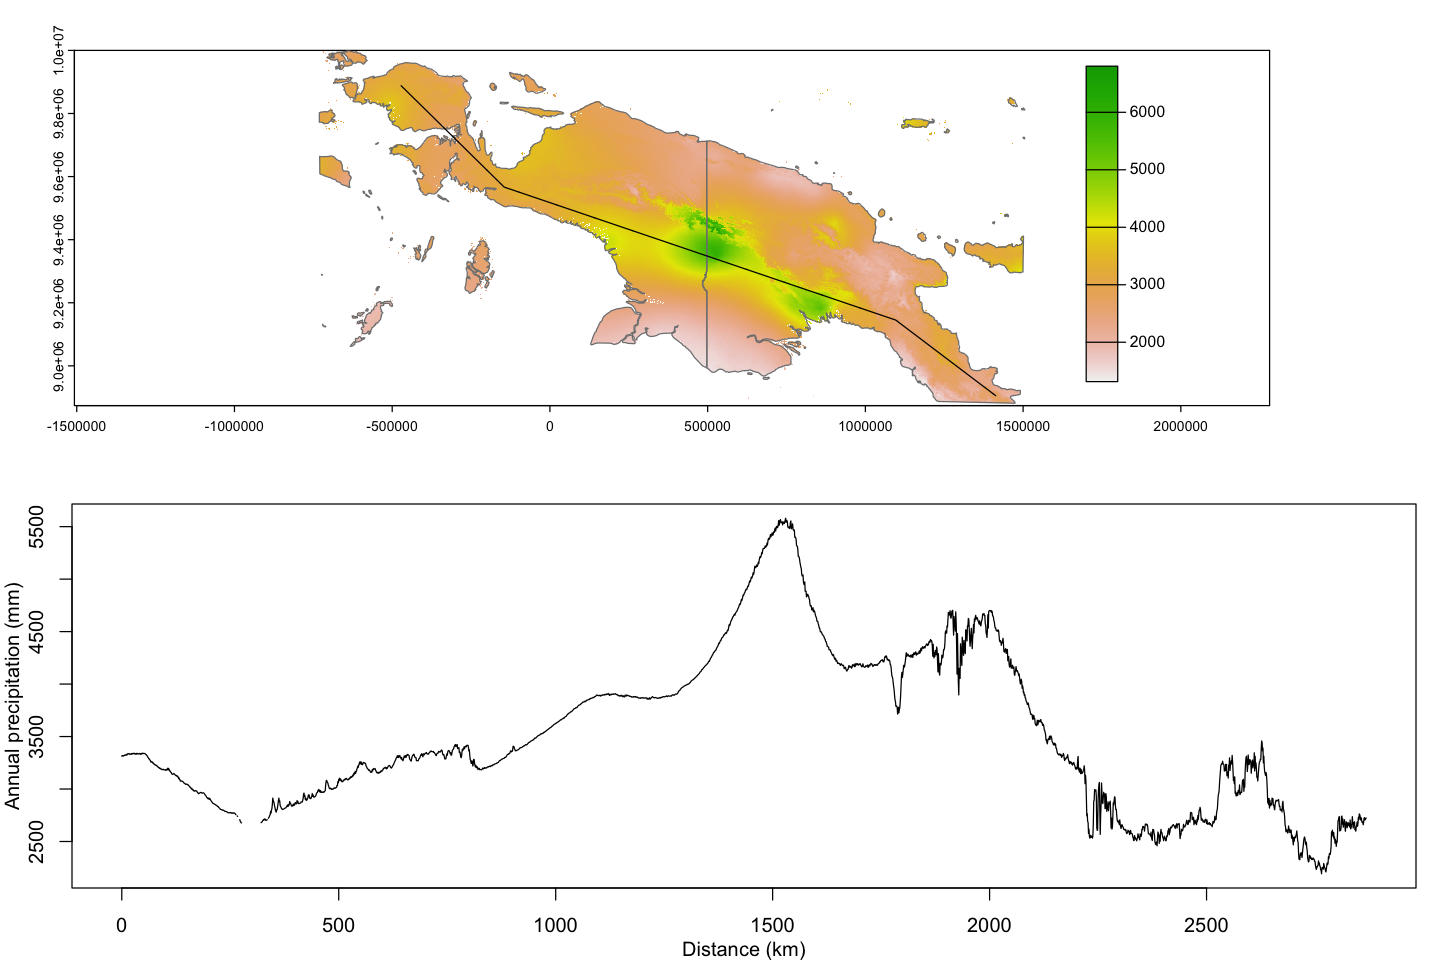

In [112]:
# Get the precipitation data
ng_prec <- worldclim_tile(var='prec', res=0.5, lon=140, lat=-10, path='data')

# Reduce to the extent of New Guinea - crop early to avoid unnecessary processing!
ng_extent <- ext(130, 150, -10, 0)
ng_prec <- crop(ng_prec, ng_extent)

# Calculate annual precipitation
ng_annual_prec <- sum(ng_prec)

# Now reproject to UTM 54S. The code here is using reprojecting the extent of the
# raster data to get sensible values for the UTM 54S extent. We are then picking extent 
# values here that create a neat 1000m grid with sensible cell edges
ng_extent_poly <- st_as_sfc(st_bbox(ng_extent, crs=4326))
ng_extent_utm <- ext(-732000, 1506000, 8874000, 10000000)

# Create the raster and reproject the data
ng_template_utm <- rast(ng_extent_utm, res=1000, crs="+init=EPSG:32754")
ng_annual_prec_utm <- project(ng_annual_prec, ng_template_utm)

# Create and reproject the transect and then segmentize it to 1000m
transect <-  st_linestring(cbind(x=transect_long, y=transect_lat))
transect <- st_sfc(transect, crs=4326)
transect_utm <- st_transform(transect, crs=32754)
transect_utm <- st_segmentize(transect_utm, dfMaxLength=1000)

# Extract the transect data
transect_data <- extract(ng_annual_prec_utm, st_sf(transect_utm), xy=TRUE)

# Now we can use Pythagoras to find the distance along the transect
transect_data$dx <- c(0, diff(transect_data$x))
transect_data$dy <- c(0, diff(transect_data$y))
transect_data$distance_from_last <- with(transect_data, sqrt(dx^2 + dy^2))
transect_data$distance <- cumsum(transect_data$distance_from_last) / 1000

# Get the natural earth high resolution coastline.
ne_10_ng  <- st_crop(ne_10, ng_extent_poly)
ne_10_ng_utm <-  st_transform(ne_10_ng, crs=32754)

par(mfrow=c(2,1), mar=c(3,3,1,1), mgp=c(2,1,0))
plot(ng_annual_prec_utm, plg=list(ext=c(1700000, 1800000, 8950000, 9950000)))

plot(st_geometry(ne_10_ng_utm), add=TRUE, col=NA, border='grey50')
plot(transect_utm, add=TRUE)

par(mar=c(3,3,1,1))
plot( sum ~ distance, data=transect_data, type='l', 
     ylab='Annual precipitation (mm)', xlab='Distance (km)')

### Fishing pressure in Fiji

This exercise is quite a bit harder - you will probably need to read more help files (or
peek at the code) but see how you go!

Researchers have identified 7 commonly used fishing sites around the island of Kadavu in
Fiji. The have also conducted surveys of the coastal villages known to use these sites
and are trying to identify how many households are likely to use site. We are going to
use the simplifying assumption that each village will *always* use the closest site.

We can't just use `st_distance` because we need the distances to reflect travel
distances through the sea rather than straight line distances. So we are going to need
to use a new tool: **cost distance analysis**. Cost distance models use a raster to
define a cost surface: moving from a cell to a neighbouring cell has a cost which is
derived from the values in the raster. This gives us a way to ask what the cost of
getting from A to B is, where movement is allowed to avoid areas that are expensive to
traverse.

We are going to do this relatively simply. There are packages which provide more
complicated options for calculating least cost paths - such as `gdistance` and
`leastcostpath` - but here we have a fairly simple situation:

- We will be using a projected coordinate system, so we don't have to worry about
  variation in distances between cells.
- We will treat travel through the sea as having *equal cost everywhere* and *the same
  costs in all directions*.

We're also going to be using some data in an Excel file. It is really common to use
Excel to arrange and manage data tables. If you use R you then typically end up
exporting CSVs to load, but there is a better way: read the data directly from Excel.
This means that you don't have to maintain multiple versions of the same data in
different formats.

#### Loading the data

- Use `geodata::gadm()` to obtain the GADM Level 2 vector data for Fiji
  (`country='FJI'`) and then extract Kadavu.
- Use `openxlsx::readWorbook` to load the data from each of the `Villages` and
  `Field sites` worksheets from the `FishingPressure.xlsx` spreadsheet and convert those
  tables into `sf` objects with POINT data.
- All of those data are in WGS84 coordinates, so convert them to a projection system
  appropriate to Fiji (UTM 60S: EPSG:32760).

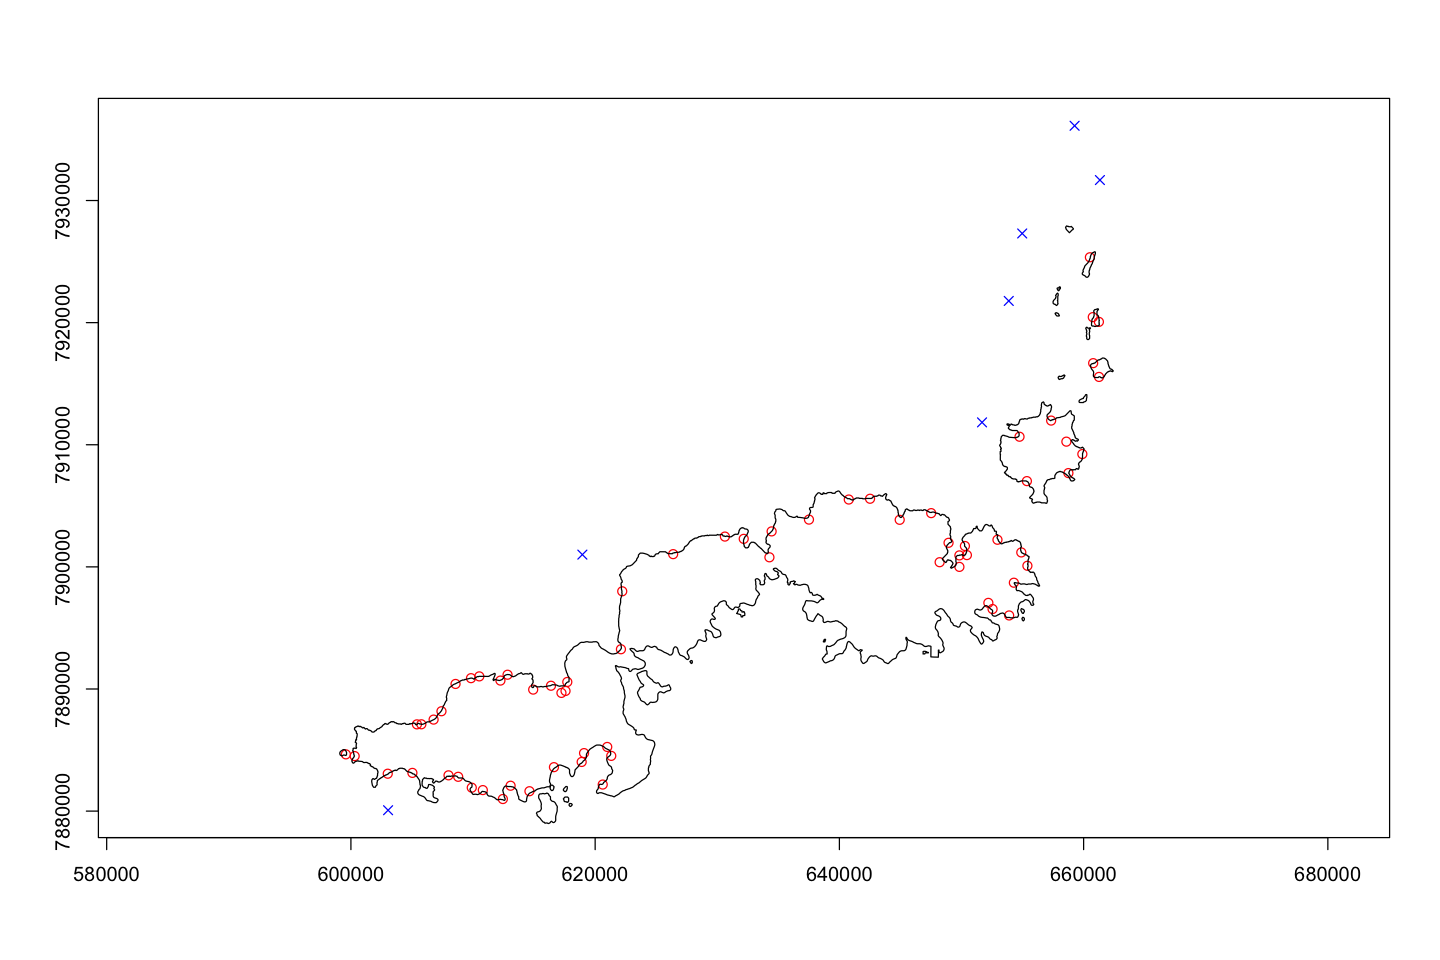

In [113]:
# Download the GADM data for Fiji, convert to sf and then extract Kadavu
fiji <- gadm(country='FJI', level=2, path='data/fiji')
fiji <- st_as_sf(fiji)
kadavu <- subset(fiji, NAME_2 == 'Kadavu')

# Load the villages and sites and convert to sf
villages <- readWorkbook('data/fiji/FishingPressure.xlsx', 'Villages')
villages <- st_as_sf(villages, coords=c('long','lat'), crs=4326)
sites <- readWorkbook('data/fiji/FishingPressure.xlsx', 'Field sites', startRow=3)
sites <- st_as_sf(sites, coords=c('Long','Lat'), crs=4326)

# Reproject the data UTM60S
kadavu <- st_transform(kadavu, 32760)
villages <- st_transform(villages, 32760)
sites <- st_transform(sites, 32760)

# Map to check everything look right.
plot(st_geometry(sites), axes=TRUE, col='blue', pch=4)
plot(st_geometry(villages), add=TRUE, col='red')
plot(st_geometry(kadavu), add=TRUE)

#### Create the cost surface

The cost surface should assign a uniform cost to moving through the sea and an infinite
cost (`NA`) to moving over land. The resolution of your cost surface raster matters: a
very fine resolution will give very precise distances but take a long time to run; a
coarse resolution will run quickly but the distances will be very crude. So, you need
to:

- pick extents to cover the islands and sites.,
- pick a resolution,
- use `st_rasterize` to convert the vector coastline into a raster and create the
  surface.

Remember from above the difference between rasterizing a polygon and a linestring: cells
containing coastline contain sea so should be available for movement.

In [114]:
options(repr.plot.width=12, repr.plot.height=5) # Change plot sizes (in cm)

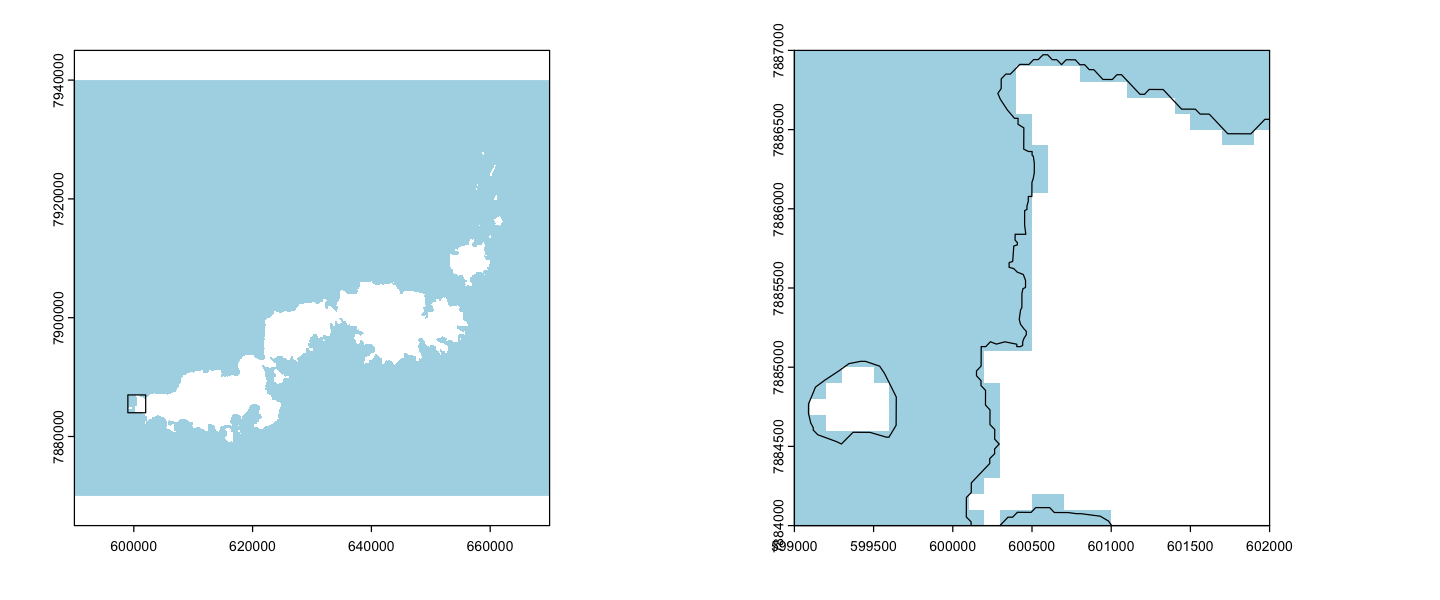

In [115]:
# Create a template raster covering the whole study area, at a given resolution
res <- 100
r <- rast(xmin=590000, xmax=670000, ymin=7870000, ymax=7940000, crs='EPSG:32760', res=res)

# Rasterize the island as a POLYGON to get cells that cannot be traversed
kadavu_poly <- rasterize(kadavu, r, field=1, background=0)

# Rasterize the island as a MULTILINESTRING to get the coastal 
# cells that _can_ be traversed
coast <- st_cast(kadavu, 'MULTILINESTRING')
kadavu_lines <- rasterize(coast, r, field=1, background=0)

# Combine those to give cells that are in the sea (kadavu_poly=0) or 
# on the coast (kadavu_lines=1)
sea_r <- (! kadavu_poly) | kadavu_lines

# Set the costs
sea_r[sea_r == 0] <- NA
sea_r[! is.na(sea_r)] <- 1

# Plot the map and then zoom in to show that the coastal cells can
# be travelled through
par(mfrow=c(1,2), mar=c(2,2,1,1))
plot(sea_r, col='lightblue')
zoom <- ext(599000, 602000, 7884000, 7887000)
plot(zoom, add=TRUE)

plot(sea_r, ext=zoom, col='lightblue')
plot(st_geometry(kadavu), add=TRUE)

#### Finding launch points

The villages are not all on the coast! If the village is too far inland then it may sit
in a cell with an infinite travel cost. So we need to find the closest point on the
coast to each village using `st_nearest_points`. All points within a polygon are part of
that polygon, so we have to explicitly convert the island polygon to a MULTILINESTRING
showing the coast to find point on the coast.

The output of `st_nearest_points` is a line that joins each village point to the nearest
point on the coast. The second points on each of these lines are our nearest launch
points and we can use `st_line_sample` with `sample=1` to extract them.

In [116]:
options(repr.plot.width=3, repr.plot.height= 3) # Change plot sizes (in cm)

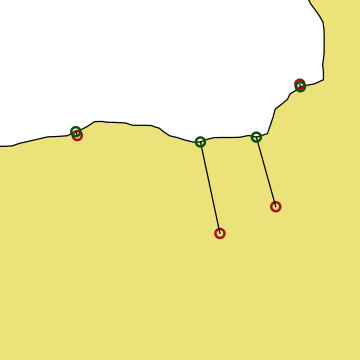

In [117]:
# Find the nearest points on the coast to each village
village_coast <- st_nearest_points(villages, coast)

# Extract the end point on the coast and convert from MULTIPOINT to POINT
launch_points <- st_line_sample(village_coast, sample=1)
launch_points <- st_cast(launch_points, 'POINT')

# Zoom in to a bay on Kadavu
par(mar=c(0,0,0,0))
plot(st_geometry(kadavu), xlim=c(616000, 618000), ylim=c(7889000, 7891000), col='khaki')
 # Plot the villages, lines to the nearest coast and the launch points.
plot(st_geometry(villages), add=TRUE, col='firebrick', lwd=2)
plot(village_coast, add=TRUE, col='black')
plot(launch_points, add=TRUE, col='darkgreen', lwd=2)

We can add the launch points in to our `villages` object. It is possible to have more
than one geometry associated with a row of data: you just have to set which one is being
used.

In [118]:
villages$launch_points <- launch_points
st_geometry(villages) <- 'launch_points'

#### Find distances

We will use the `terra::gridDistance` function to calculate distances from a village.
This:

- Calculates distance across a grid to target cells with a particular value,
- Allows movement into the 8 cells surrounding a cell, with diagonal moves being more
  expensive.
- Handles NA cells as barrier cells which block movement.

The code below shows a simple example of how the calculation works - note the added
costs of moving around the blocking cell into the bottom right corner.

In [119]:
options(repr.plot.width=4, repr.plot.height= 4) # Change plot sizes (in cm)

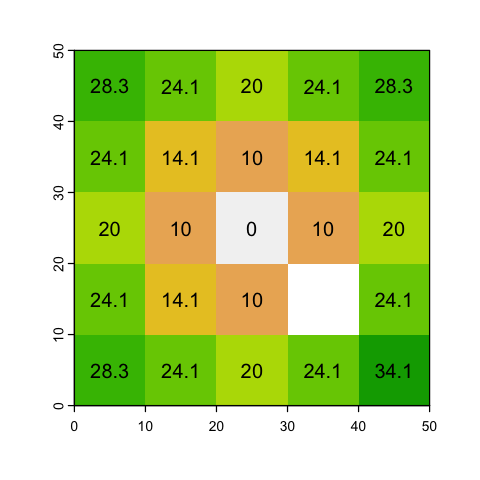

In [120]:
r <- rast(xmin=0, ymin=0, xmax=50, ymax=50, res=10, crs='EPSG:32760')

# Set cell values:
values(r) <- 1  # Set all cells to be non-NA
r[3,3] <- 0     # This is a target cell
r[4,4] <- NA    # Set one NA cell

# Calculate and plot distances
d <- gridDistance(r)
plot(d, legend=NULL)
text(d, digits=1)

Scaling that up to give an example for a single site:

In [121]:
options(repr.plot.width=7, repr.plot.height= 5.5) # Change plot sizes (in cm)

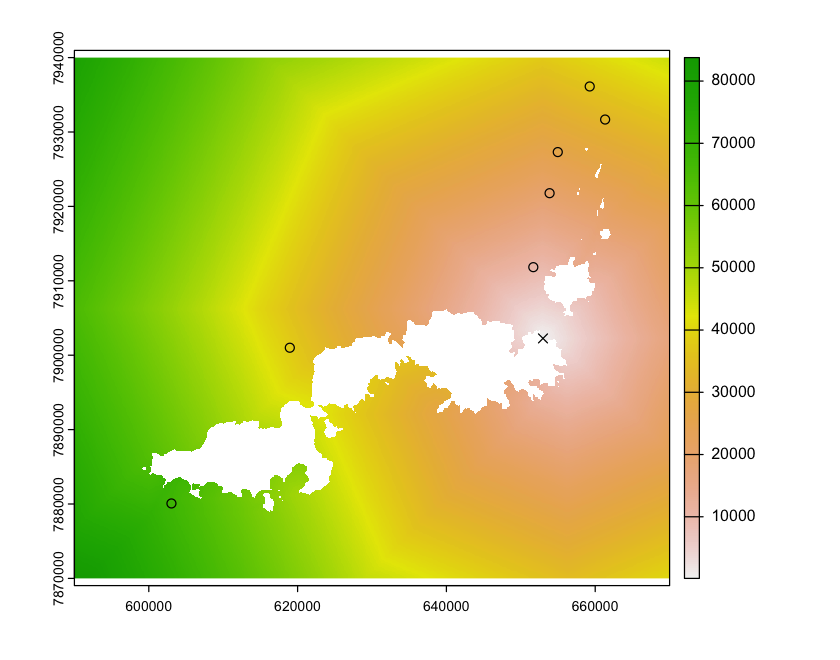

In [122]:
# Make a copy of the sea map
dist <- sea_r

# Find the location of a site and make that the target
site_idx <- 49
village_cell <- cellFromXY(dist, st_coordinates(villages[site_idx,]))
dist[village_cell] <- 0

# Now we can calculate the cost distance for each launch point to each site...
costs <- gridDistance(dist)

plot(costs, plg=list(ext=c(672000, 674000, 7870000, 7940000)))
plot(st_geometry(villages[site_idx,]), add=TRUE, pch=4)
plot(st_geometry(sites), add=TRUE)

In [123]:
# And grab the costs at each fishing site
distances_to_site <- extract(costs, sites)
print(distances_to_site)

# and find the smallest distance
nearest_site <- which.min(distances_to_site$layer)

  ID    layer
1  1 36509.55
2  2 32879.39
3  3 25928.43
4  4 19872.79
5  5 10138.48
6  6 38220.82
7  7 67877.16


#### Loop over sites

We now need to wrap that process in a loop to find the nearest site for each village -
this can take a little time to run!

In [124]:
# Create fields to hold the nearest fishing site data
villages$nearest_site_index <- NA
villages$nearest_site_name <- NA

# Loop over the sites
for (site_idx in seq(nrow(villages))) {

    # Make a copy of the sea map
    dist <- sea_r

    # Find the location of a site and make that the target
    village_cell <- cellFromXY(dist, st_coordinates(villages[site_idx,]))
    dist[village_cell] <- 0

    # Now we can calculate the cost distance for each launch point to each site...
    costs <- gridDistance(dist)
    
    # And find the nearest site
    distances_to_site <- extract(costs, sites)
    nearest_site <- which.min(distances_to_site$layer)
    
    # Find the index and name of the lowest distance in each row
    villages$nearest_site_index[site_idx] <- nearest_site
    villages$nearest_site_name[site_idx] <- sites$Name[nearest_site]

}

And now we can work out the fishing load for each site and map which villages prefer
which site:

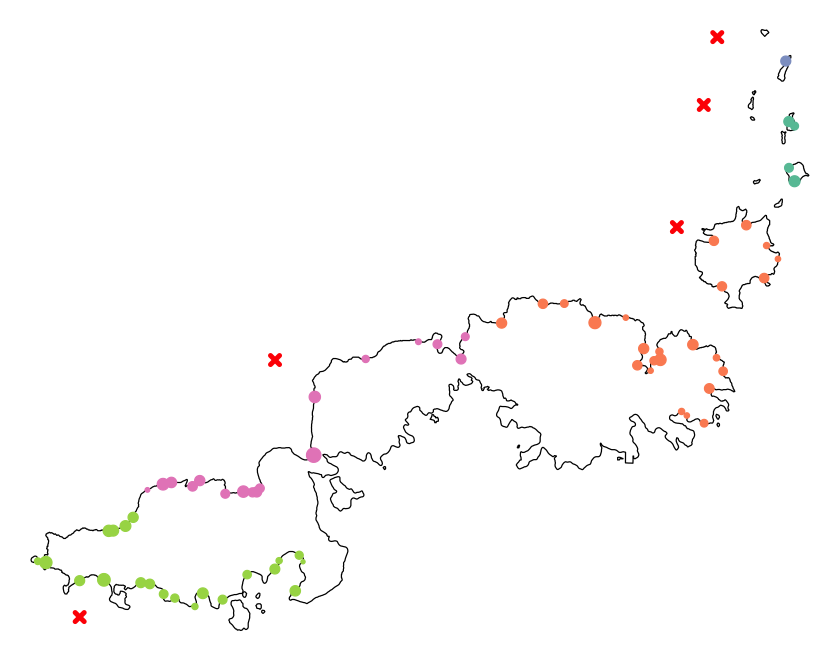

In [125]:
# Find the total number of buildings  per site and merge that data
# into the sites object
site_load <- aggregate(building_count ~ nearest_site_name, data=villages, FUN=sum)
sites_with_load <- merge(sites, site_load, by.x='Name', by.y='nearest_site_name', all.x=TRUE)

# Now build up a complex plot
par(mar=c(0,0,0,0))
plot(st_geometry(kadavu))

# add the villages, colouring by nearest site and showing the village 
# size using the symbol size (cex)
plot(villages['nearest_site_name'], add=TRUE, pch=20, cex=log10(villages$building_count))

# Add the sites
plot(st_geometry(sites_with_load), add=TRUE, col='red', pch=4, lwd=4)

In [126]:
print(sites_with_load)

Simple feature collection with 7 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 603043.7 ymin: 7880073 xmax: 661334.1 ymax: 7936121
Projected CRS: WGS 84 / UTM zone 60S
    Name Date S-N building_count                 geometry
1 NAR_AP 24th   6            165 POINT (653869.9 7921777)
2 NAR_AR 22nd   7            758 POINT (651680.9 7911833)
3 NAR_CP 20th   3             NA POINT (659262.1 7936121)
4 NAR_DU 21st   4             NA POINT (661334.1 7931676)
5 NAR_HP 19th   5             47 POINT (654969.6 7927302)
6     NR 25th   8            902 POINT (618952.7 7901004)
7 SAR_DB 26th   9            943 POINT (603043.7 7880073)


## Using ggplot to make maps

As you will have seen in the last couple of weeks, `ggplot` is a popular package for
plotting and can be used for with `sf` objects in maps too. There is also a package
called `tmap` which works in a very similar way to `ggplot` but is more tightly focussed
on map plotting. If you end up creating lots of maps, that might be a good place to
look, and there is an online book to use as a guide:

[https://r-tmap.github.io/tmap-book/](https://r-tmap.github.io/tmap-book/)

Essentially GIS maps are mostly about deciding what information you want to show
and the plot order, so the simple plotting we use here can be pretty good without
needing extra tools.

Having said that, here is a `ggplot` map of the world.

In [127]:
options(repr.plot.width=10, repr.plot.height=5) # Change plot sizes (in cm)

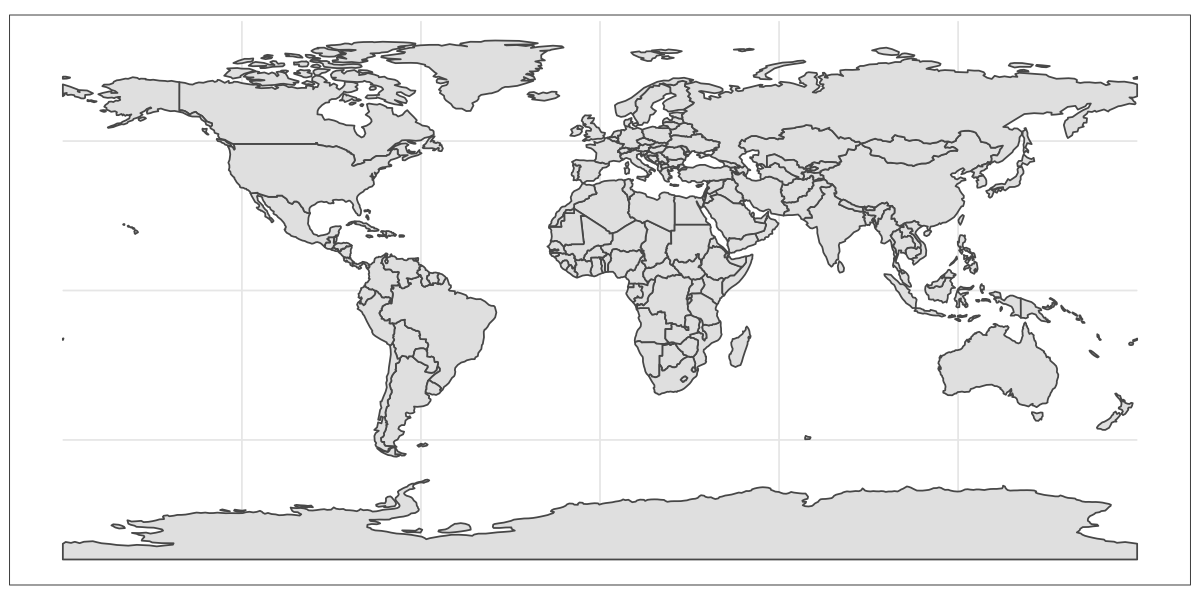

In [128]:
library(ggplot2)
ggplot(ne_110) +
       geom_sf() +
       theme_bw()

There are several `ggplot` extensions for `sf` that make it easier to colour and label
your `ggplot` maps. Here is a *bad* example:

In [129]:
options(repr.plot.width=7, repr.plot.height= 7) # Change plot sizes (in cm)

although coordinates are longitude/latitude, st_intersection assumes that they are planar



Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”


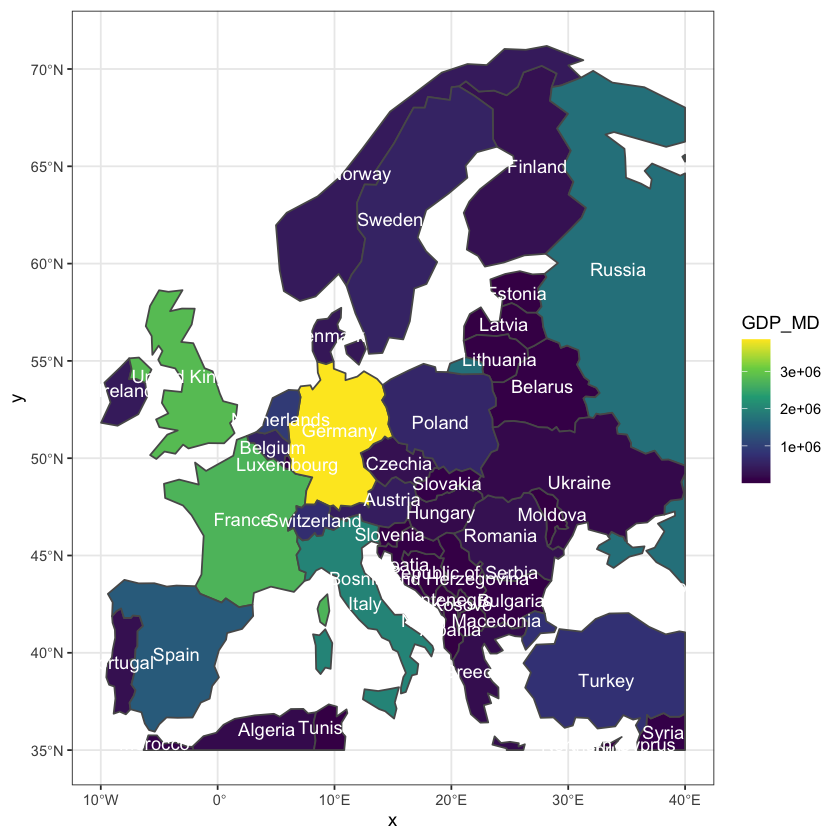

In [130]:
europe <- st_crop(ne_110, ext(-10,40,35,75))
ggplot(europe) +
       geom_sf(aes(fill=GDP_MD)) +
       scale_fill_viridis_c() +
       theme_bw() + 
       geom_sf_text(aes(label = ADMIN), colour = "white")

```{admonition} European life expectancy

That map produces warnings about lat/long data, the data scale is poor and the text
labels are crowded. Can you update the code above to create a projected map with better
labels? Use:

* The [ETRS89 / LAEA Europe](http://epsg.io/3035) (EPSG: 3035) projection.
* An appropriate transformation of the GDP scale.
* One of the other (many!) fields in the `europe` data frame that provide abbreviated
  country names.

Also, note that simply transforming and plotting the existing cropped data in `europe`
reveals the curved edges that have been cropped through countries - for example the
Russian border. This is seen in the first plot below, where the second is cropped using
the reprojected axes
```

In [131]:
options(repr.plot.width=12, repr.plot.height= 6) # Change plot sizes (in cm)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


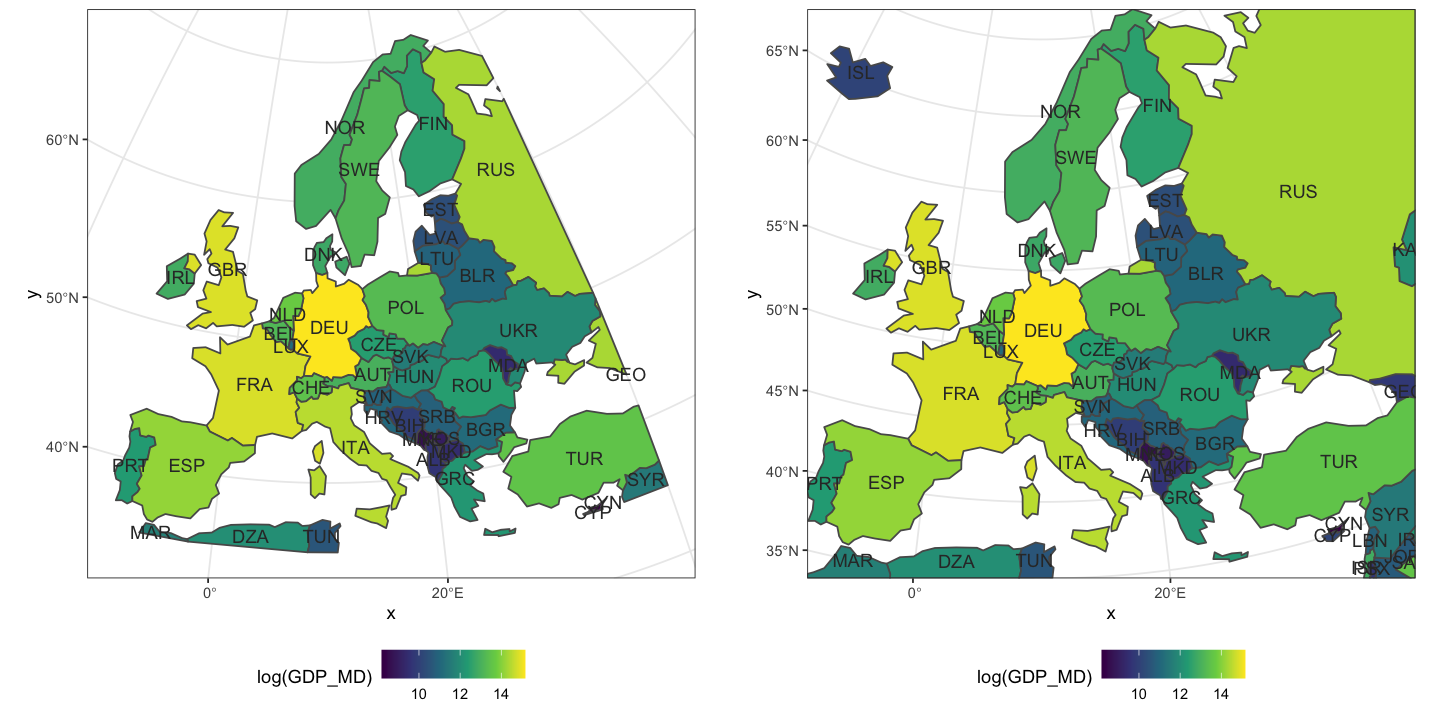

In [132]:
# Calculate the extent in the LAEA projection of the cropped data
europe_crop_laea <- st_transform(europe, 3035)

# Reproject all of the country data and _then_ crop to the previous extent
europe_laea <- st_transform(ne_110, 3035)
europe_laea <- st_crop(europe_laea, europe_crop_laea)

# Plot the two maps
p1 <- ggplot(europe_crop_laea) +
       geom_sf(aes(fill=log(GDP_MD))) +
       scale_fill_viridis_c() +
       theme_bw() + 
       theme(legend.position="bottom") +
       geom_sf_text(aes(label = ADM0_A3), colour = "grey20")

p2 <- ggplot(europe_laea) +
       geom_sf(aes(fill=log(GDP_MD))) +
       coord_sf(expand=FALSE) +
       scale_fill_viridis_c() +
       theme_bw() + 
       theme(legend.position="bottom") +
       geom_sf_text(aes(label = ADM0_A3), colour = "grey20")

library(gridExtra)
grid.arrange(p1, p2, ncol=2)

## Colour palettes

Colour palettes are an essential part of presenting spatial data, as often we read the
data as a colour scale on a map, rather than an x- or y-axis of continuous variables.
There has been a lot of discussion amongst researches on the best colour scales to use.
Rainbow colours used to be a the most common used, but are not appropriate for colour
blindness and interpreting the data can be hard. Rainbow can be found amongst the R base
colours, but I would not recommend using them as there are plenty more better options.

![R base colour palettes.](images/rbase.png)

The `hcl.colors` function - as used above - is a far better choice in many cases. There
are a wide range of palettes (see `hcl.pals()`) with different use cases. There are also
some specific packages that provide extra colour schemes.

### Viridis

The `viridis` package contains the `viridis` palette, but also these other palettes:

![Colour palettes from the viridis package.](images/viridis.png)

Re-plot the life expectancy map of Europe using each of the other 3 palettes in the
`viridis` pacakge. Which one do you prefer?

With `ggplot`, you can use the functions `scale_color_viridis()` to colour points, lines
or texts and `scale_fill_viridis()` to fill areas. Use the `option` argument to select
which pallette in `viridis` you wish, with the viridis palette being the default.

### Brewer

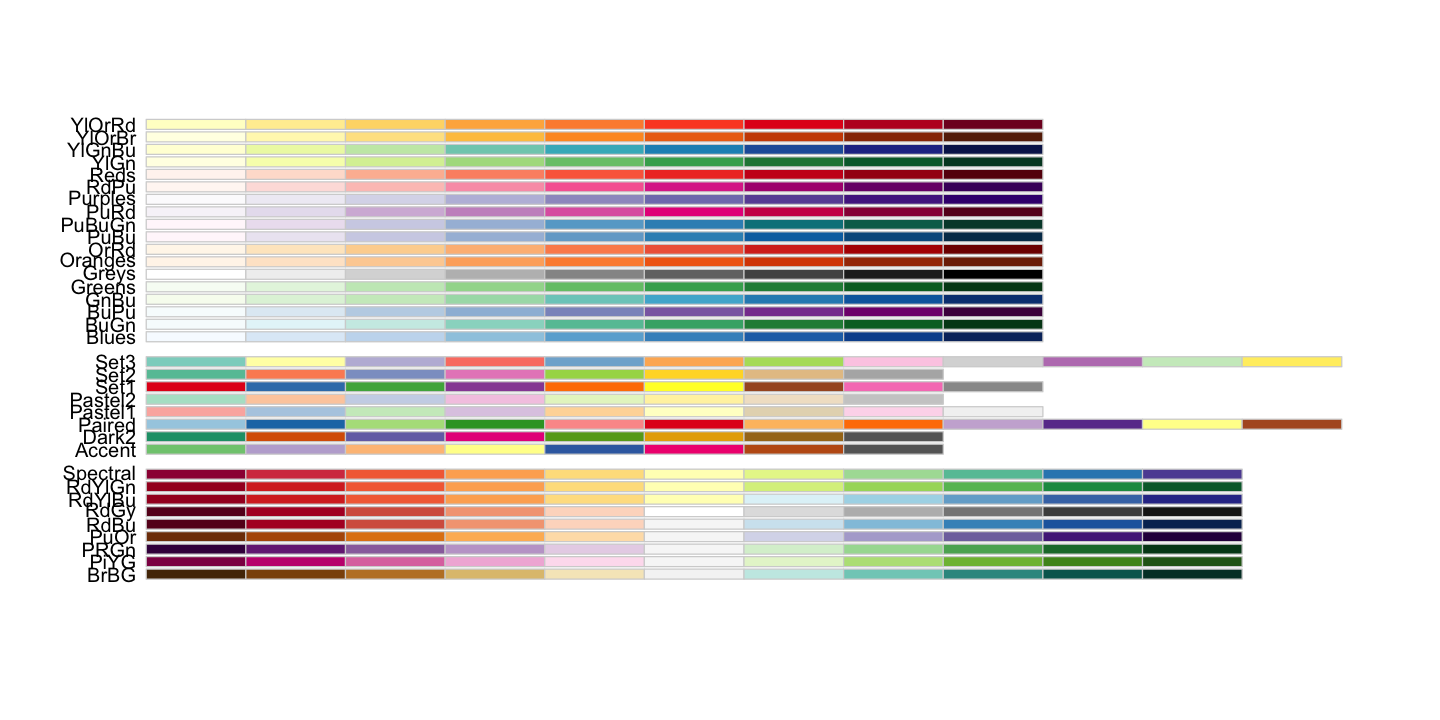

In [133]:
library(RColorBrewer)
display.brewer.all()

The first group are spectral palettes that are most similar to `viridis` and good for
representing continous data. The second group are qualitative palettes which should be
used for categorical data (e.g. bar plots) and the final group put equal emphasis on the
mid-range values as well as those at the end. These should be used when representing
changes a value, e.g. temperature, where the white middle colour shows no change has
occurred in the data.

The brewer packages has a neat way of showing colours that are colourblind-friendly.

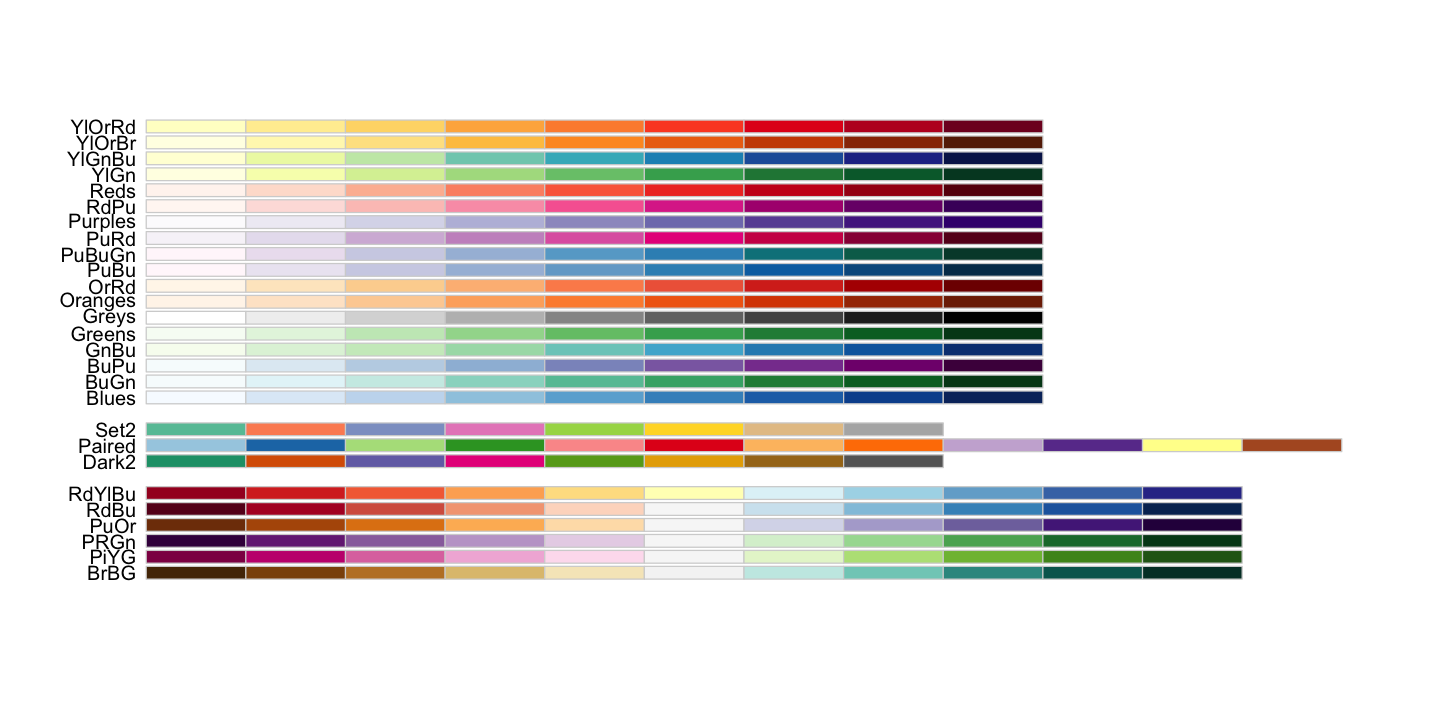

In [134]:
display.brewer.all(colorblindFriendly = TRUE)

As with `viridis` you can use `scale_color_brewer()` and `scale_fill_brewer()` in
`ggplot`.

<!-- ## Extensions

### GIF of WHO data
Make a GIF which mapping the time series of the global life expectancy for all countries from 2000 to 2016. Hint use the `tmap` package and `tmap_animation()`. See the 'Geocomputation in R' book for more information. -->